In [491]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import lognorm
# norm.ppf(0.95)
# norm.cdf(norm.ppf(0.95))
from scipy import stats
import numpy as np
import pylab as pl
import random
import pandas as pd
import math
from google.cloud import bigquery
import pandas as pd
import numpy as np



#### Get data

In [492]:

client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))
# read data main table for model
query = """
    select * FROM `gaf-np-ds.warranty_claims.warranty_claims_raw_data_v1` 
"""
raw_data = pd.read_gbq(query, dialect='standard')


raw_data.shape



Client creating using default project: gaf-np-ds


Downloading: 100%|██████████| 40849/40849 [00:08<00:00, 4785.38rows/s]


(40849, 20)

In [493]:
# r=0.8912771147
# r=0.7377168174
# r=0.1208249615
# mu=380
# si=280
# norm.ppf(r, loc=mu, scale=si)  #inverse normal


In [494]:
# a=-.2
# b=645
# #=B12*EXP($B$7)
# b*math.exp(a)


#### Select code V83

In [495]:
# select v83
code_to_filter=['V83']
#clean_data=raw_data[raw_data['DefectCode'].isin(['V83','V8','V98'])]
clean_data=raw_data[raw_data['DefectCode'].isin(code_to_filter)]
print(code_to_filter,' data ',clean_data.shape)
#clean_data.head(2)

['V83']  data  (2750, 20)


In [496]:
print(clean_data['PurchaseDate'].dtype)
print(clean_data['MfgDate'].dtype)
print(clean_data['RecvdDt'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


#### Create new fields

In [498]:
pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore')

#clean_data['From_mfg_claim_days']=(pd.to_datetime(clean_data['RecvdDt'])-pd.to_datetime(clean_data['MfgDate'])).dt.total_seconds() / 24*3600 
clean_data['From_pur_claim_days']=(clean_data['RecvdDt']-clean_data['PurchaseDate'])/(np.timedelta64(1,'h')*24)
clean_data['PurchaseDate_Y']=clean_data['PurchaseDate'].dt.year
clean_data['PurchaseDate_M']=clean_data['PurchaseDate'].dt.month
clean_data['MfgDate_Y']=clean_data['MfgDate'].dt.year
clean_data['MfgDate_M']=clean_data['MfgDate'].dt.month
clean_data['RecvdDt_Y']=clean_data['RecvdDt'].dt.year
clean_data['RecvdDt_M']=clean_data['RecvdDt'].dt.month
clean_data.head(2)
clean_data['count']=1
#log of From_pur_claim_days
clean_data['From_pur_claim_days_log']=clean_data['From_pur_claim_days'].apply(lambda x:np.log(x))

#clean_data[clean_data['Claim'].isin(['17008872','30127922'])].head(5)
#clean_data.head(2)

#### Select claim year 2019

In [8]:
# from sheet details 11 2019
# mean std of From_pur_claim_days and From_pur_claim_days_log
year=2019
clean_data_2019=clean_data[clean_data['RecvdDt_Y']==year]

print('mean of From_pur_claim_days for claim year ',year,clean_data_2019['From_pur_claim_days'].mean())
print('std of From_pur_claim_days for claim year ',year,clean_data_2019['From_pur_claim_days'].std())
print('log mean of From_pur_claim_days for claim year ',year,math.log(clean_data_2019['From_pur_claim_days'].mean(),10))
print('log std of From_pur_claim_days for claim year ',year,math.log(clean_data_2019['From_pur_claim_days'].std(),10))
print('mean of From_pur_claim_days(years) for claim year ',year,clean_data_2019['From_pur_claim_days'].mean()/365)
print('std of From_pur_claim_days(years) for claim year ',year,clean_data_2019['From_pur_claim_days'].std()/365)
print('mean of From_pur_claim_days(weeks) for claim year ',year,52*clean_data_2019['From_pur_claim_days'].mean()/365)
print('std of From_pur_claim_days(weeks) for claim year ',year,52*clean_data_2019['From_pur_claim_days'].std()/365)
# print('mean of From_pur_claim_days_log for claim year ',year,clean_data_2019['From_pur_claim_days_log'].mean())
# print('std of From_pur_claim_days_log for claim year ',year,clean_data_2019['From_pur_claim_days_log'].std())
mean_log=math.log(clean_data_2019['From_pur_claim_days'].mean(),10)
sd_log=math.log(clean_data_2019['From_pur_claim_days'].std(),10)
mean=52*clean_data_2019['From_pur_claim_days'].mean()/365
sd=52*clean_data_2019['From_pur_claim_days'].std()/365

mean of From_pur_claim_days for claim year  2019 2592.078703703704
std of From_pur_claim_days for claim year  2019 648.2901324866222
log mean of From_pur_claim_days for claim year  2019 3.4136481839521444
log std of From_pur_claim_days for claim year  2019 2.8117694113310794
mean of From_pur_claim_days(years) for claim year  2019 7.101585489599189
std of From_pur_claim_days(years) for claim year  2019 1.776137349278417
mean of From_pur_claim_days(weeks) for claim year  2019 369.2824454591578
std of From_pur_claim_days(weeks) for claim year  2019 92.35914216247768


#### Claim simulation

In [9]:
# from sheet SPA_SIM
from scipy.stats import skew
Random_Num=np.random.rand(1000)
#r=np.array([.638578765])
#print(r.shape,r)
#r=random.random()  #between 1-1000
#r=0.638578765
#Simulated_Payment_Amount_=stats.lognorm(sd_log, scale=np.exp(mean_log)).ppf(r)   #lognormal inverse
Simulated_Payment_Amount_=stats.lognorm(sd_log, scale=np.exp(mean_log)).ppf(Random_Num)   #lognormal inverse
#Simulated_Payment_Amount_
Ranked_Simulated_Payment_Amount_=Simulated_Payment_Amount_.copy()
Ranked_Simulated_Payment_Amount_.sort()  #sort in place
print('The simulated sum of 1K claims would amount to',np.sum(Simulated_Payment_Amount_))
print('The median claim value was',np.median(Ranked_Simulated_Payment_Amount_))
print('The average claim value was',np.mean(Ranked_Simulated_Payment_Amount_))
print('The skew value was',skew(Ranked_Simulated_Payment_Amount_))
# plt.plot(Ranked_Simulated_Payment_Amount_)
# plt.xlim(990,1000)
# plt.show()

The simulated sum of 1K claims would amount to 710449.5310377029
The median claim value was 28.072811571504424
The average claim value was 710.449531037703
The skew value was 9.295538692158187


In [10]:
# from sheet claim_time_weeks
Random_Num=np.random.rand(1000)
#r=np.array([.638578765])
#print(r.shape,r)
#r=random.random()  #between 1-1000
r=0.6495481332
print(norm.ppf(r, loc=mean, scale=sd))

Simulated_Length_Weeks=norm.ppf(Random_Num, loc=mean, scale=sd)   
Simulated_Length_Weeks[Simulated_Length_Weeks < 0] = 0
#Simulated_Payment_Amount_
Ranked_Product_Manufacture_Date_and_Claims_Received_Date=Simulated_Length_Weeks.copy()
Ranked_Product_Manufacture_Date_and_Claims_Received_Date.sort()  #sort in place
print('The median claim length was',np.median(Ranked_Product_Manufacture_Date_and_Claims_Received_Date))
print('The average claim length was',np.mean(Ranked_Product_Manufacture_Date_and_Claims_Received_Date))
print('The skew value was',skew(Ranked_Product_Manufacture_Date_and_Claims_Received_Date))


404.75766647005526
The median claim length was 371.9864911368138
The average claim length was 370.01469236905245
The skew value was -0.0984917426766772


In [11]:
# from sheet claim_time_years
mean=clean_data_2019['From_pur_claim_days'].mean()/365
sd=clean_data_2019['From_pur_claim_days'].std()/365
Random_Num=np.random.rand(1000)
#r=np.array([.638578765])
#print(r.shape,r)
#r=random.random()  #between 1-1000
r=0.6495481332
print(norm.ppf(r, loc=mean, scale=sd))

Simulated_Length_Weeks=norm.ppf(Random_Num, loc=mean, scale=sd)  
Simulated_Length_Weeks[Simulated_Length_Weeks < 0] = 0
Simulated_Length_years=Simulated_Length_Weeks/52
#Simulated_Payment_Amount_
Ranked_Product_Manufacture_Date_and_Claims_Received_Date=Simulated_Length_Weeks.copy()
Ranked_Product_Manufacture_Date_and_Claims_Received_Date.sort()  #sort in place
print('The median claim length was',np.median(Ranked_Product_Manufacture_Date_and_Claims_Received_Date))
print('The average claim length was',np.mean(Ranked_Product_Manufacture_Date_and_Claims_Received_Date))
print('The skew value was',skew(Ranked_Product_Manufacture_Date_and_Claims_Received_Date))


7.783801278270293
The median claim length was 7.1734553436569755
The average claim length was 7.176193566212527
The skew value was -0.015060487288955413


In [12]:
## claim_simulator_complete sheet
Base_Units=165000000
Claim_Rate=0.07
Expected_Claims=645
Base_Adjuster=2.2
Adjusted_Claims=1419
Decay_Rate=-0.15
no_of_elements=50
Estimated_Claim_Reserve_Growth_Rate=.05

Projected_Claims_Remaining=np.zeros(no_of_elements)
print(Projected_Claims_Remaining.shape)
Projected_Claims_Remaining[0]=Expected_Claims*np.exp(Decay_Rate)
for i in range(1,no_of_elements):
    Projected_Claims_Remaining[i]=Projected_Claims_Remaining[i-1]*np.exp(Decay_Rate)
print(Projected_Claims_Remaining.shape)

Projected_Percent_Claims_Remaining=Projected_Claims_Remaining/Expected_Claims
Claims_Total_SIM=Projected_Claims_Remaining.copy()

Claims_Total_SIM=np.concatenate([np.array([Expected_Claims]),Claims_Total_SIM])
Claims_Total_SIM=Claims_Total_SIM[:-1]

Claims_Total_SIM
#Projected_Claims_Remaining
    
    

(50,)
(50,)


array([6.45000000e+02, 5.55156645e+02, 4.77827752e+02, 4.11270158e+02,
       3.53983505e+02, 3.04676427e+02, 2.62237431e+02, 2.25709848e+02,
       1.94270267e+02, 1.67209968e+02, 1.43918953e+02, 1.23872191e+02,
       1.06617783e+02, 9.17667762e+01, 7.89843962e+01, 6.79824998e+01,
       5.85130799e+01, 5.03626746e+01, 4.33475557e+01, 3.73095870e+01,
       3.21126591e+01, 2.76396218e+01, 2.37896430e+01, 2.04759355e+01,
       1.76238010e+01, 1.51689461e+01, 1.30560329e+01, 1.12374316e+01,
       9.67214705e+00, 8.32489411e+00, 7.16530277e+00, 6.16723325e+00,
       5.30818685e+00, 4.56879876e+00, 3.93240153e+00, 3.38464937e+00,
       2.91319471e+00, 2.50740992e+00, 2.15814772e+00, 1.85753496e+00,
       1.59879515e+00, 1.37609574e+00, 1.18441658e+00, 1.01943680e+00,
       8.77437384e-01, 7.55217355e-01, 6.50021602e-01, 5.59478777e-01,
       4.81547846e-01, 4.14472072e-01])

In [13]:
Simulated_Payment_Amount_.shape
v1=list(range(1,1001))  #index starts from 1 as per excel
v2=Simulated_Payment_Amount_  #.tolist()
v3=np.cumsum(v2)  #cul sum of Simulated_Payment_Amount_
print(v2[:5])
v3[:5]
#search Claims_Total_SIM in vloopup(randomly)[Simulated_Payment_Amount_(SPA)][lognormalinverse of random no] and get cumulative sum
Claims_Total_SIM=Claims_Total_SIM.astype(int)
Projected_Settlement_Payment_Amount_Year_AMT=v3[Claims_Total_SIM]
Projected_Settlement_Payment_Amount_Year_AMT
#vlookup=
Projected_Settlement_Payment_Amount_Year_Projected_SUM=Projected_Settlement_Payment_Amount_Year_AMT.copy()   #cumulative sum reversely Projected_Settlement_Payment_Amount_Year_AMT 
Projected_Settlement_Payment_Amount_Year_Projected_SUM = Projected_Settlement_Payment_Amount_Year_Projected_SUM[::-1]  #reverse
Projected_Settlement_Payment_Amount_Year_Projected_SUM=np.cumsum(Projected_Settlement_Payment_Amount_Year_Projected_SUM)
Projected_Settlement_Payment_Amount_Year_Projected_SUM = Projected_Settlement_Payment_Amount_Year_Projected_SUM[::-1]  #reverse

Projected_Settlement_Payment_Amount_Year_Projected_SUM


Invest_Claim_Reserve=np.zeros(no_of_elements)
Invest_Claim_Reserve[0]=(Projected_Settlement_Payment_Amount_Year_Projected_SUM[0]*(Estimated_Claim_Reserve_Growth_Rate+1))-Projected_Settlement_Payment_Amount_Year_AMT[0]

for i in range(1,no_of_elements):
    Invest_Claim_Reserve[i]=(Invest_Claim_Reserve[i-1]*(Estimated_Claim_Reserve_Growth_Rate+1))-Projected_Settlement_Payment_Amount_Year_AMT[i]

Invest_Claim_Reserve

Reserve_Growth=np.zeros(no_of_elements)
Reserve_Growth[0]=0

for i in range(1,no_of_elements):
    Reserve_Growth[i]=Invest_Claim_Reserve[i]-Invest_Claim_Reserve[i-1]-Projected_Settlement_Payment_Amount_Year_AMT[i]-Projected_Settlement_Payment_Amount_Year_AMT[i-1]
    
Year=np.array(list(range(1,no_of_elements+1)))
#Invest_Claim_Reserve, Projected_Settlement_Payment_Amount_Year_Projected_SUM, Claims_Total_SIM


[  1.60476441 121.98010566  67.33921852 322.81733214 635.95120402]


In [14]:
Projected_Settlement_Payment_Amount_Year_Projected_SUM.shape
Year.shape
Invest_Claim_Reserve.shape

(50,)

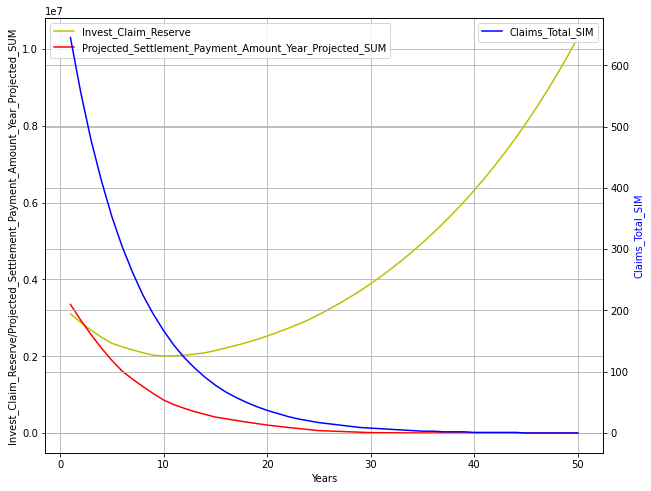

In [15]:
Projected_Settlement_Payment_Amount_Year_AMT.shape
### plotting
fig, ax1 = plt.subplots(figsize=(10,8))
ax2 = ax1.twinx()
ax1.plot(Year, Invest_Claim_Reserve, 'y-',label = 'Invest_Claim_Reserve')
ax1.plot(Year, Projected_Settlement_Payment_Amount_Year_Projected_SUM, 'r-',label='Projected_Settlement_Payment_Amount_Year_Projected_SUM')
ax2.plot(Year, Claims_Total_SIM, 'b-',label='Claims_Total_SIM')
ax1.set_ylabel('Invest_Claim_Reserve/Projected_Settlement_Payment_Amount_Year_Projected_SUM')
ax1.set_xlabel('Years')
ax1.grid(None)
ax2.set_ylabel('Claims_Total_SIM', color='b')
ax2.grid(None)
ax2.legend()  #loc=0)
ax1.legend()  #loc=2)

plt.show()

In [16]:
Claims_Total_SIM

array([645, 555, 477, 411, 353, 304, 262, 225, 194, 167, 143, 123, 106,
        91,  78,  67,  58,  50,  43,  37,  32,  27,  23,  20,  17,  15,
        13,  11,   9,   8,   7,   6,   5,   4,   3,   3,   2,   2,   2,
         1,   1,   1,   1,   1,   0,   0,   0,   0,   0,   0])

In [17]:
print(np.where(v2==35367.26501967932))
#np.in1d(v2, Claims_Total_SIM).nonzero()[0]
np.where(np.in1d(v1,Claims_Total_SIM)) 
#print(v2.shape,Claims_Total_SIM.shape)

(array([], dtype=int64),)


(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  10,  12,  14,  16,
         19,  22,  26,  31,  36,  42,  49,  57,  66,  77,  90, 105, 122,
        142, 166, 193, 224, 261, 303, 352, 410, 476, 554, 644]),)

## Analysis

In [292]:
# a=Simulated_Payment_Amount_
# a.sort()
# print(a)
# #Simulated_Payment_Amount_

In [423]:
clean_data['MfgDate_Y'].min()

1990.0

### Manufacturing date and squars

In [452]:
# With manufacturing year
#Squares
#clean_data1=clean_data[['MfgDate_Y','RecvdDt_Y','count']]
clean_data1=clean_data[['MfgDate_Y','RecvdDt_Y','Squares']]
#clean_data1=clean_data1.groupby(['MfgDate_Y','RecvdDt_Y'])['count'].sum().reset_index()
clean_data1=clean_data1.groupby(['MfgDate_Y','RecvdDt_Y'])['Squares'].sum().reset_index()
clean_data1.set_index(['MfgDate_Y'], inplace=True)
#clean_data1=clean_data1.reset_index().pivot('MfgDate_Y','RecvdDt_Y','count')
clean_data1=clean_data1.reset_index().pivot('MfgDate_Y','RecvdDt_Y','Squares')
for c in clean_data1.columns:
    clean_data1[c]=clean_data1[c].fillna(0)

clean_data1 = clean_data1[sorted(clean_data1.columns.tolist(), reverse=True)] 
clean_data1 =clean_data1.sort_index(ascending=False)
#clean_data1.index=clean_data1.index.astype('int64')
clean_data1.index = clean_data1.index.map(int)
#clean_data1
clean_data1.loc['Total',:]= clean_data1.sum(axis=0)
clean_data1.loc[:,'Total']= clean_data1.sum(axis=1)
clean_data1
clean_data_mfg_sq=clean_data1.copy()

### Manufacturing date and claim_count

In [425]:
# With manufacturing year
#Squares
clean_data1=clean_data[['MfgDate_Y','RecvdDt_Y','count']]
#clean_data1=clean_data[['MfgDate_Y','RecvdDt_Y','Squares']]
clean_data1=clean_data1.groupby(['MfgDate_Y','RecvdDt_Y'])['count'].sum().reset_index()
#clean_data1=clean_data1.groupby(['MfgDate_Y','RecvdDt_Y'])['Squares'].sum().reset_index()
clean_data1.set_index(['MfgDate_Y'], inplace=True)
clean_data1=clean_data1.reset_index().pivot('MfgDate_Y','RecvdDt_Y','count')
#clean_data1=clean_data1.reset_index().pivot('MfgDate_Y','RecvdDt_Y','Squares')
for c in clean_data1.columns:
    clean_data1[c]=clean_data1[c].fillna(0)

clean_data1 = clean_data1[sorted(clean_data1.columns.tolist(), reverse=True)] 
clean_data1 =clean_data1.sort_index(ascending=False)
#clean_data1.index=clean_data1.index.astype('int64')
clean_data1.index = clean_data1.index.map(int)
#clean_data1
clean_data1.loc['Total',:]= clean_data1.sum(axis=0)
clean_data1.loc[:,'Total']= clean_data1.sum(axis=1)
clean_data1

clean_data_mfg_cl=clean_data1.copy()

### purchase date and squars

In [426]:
# With PurchaseDate_Y year

#clean_data2=clean_data[['PurchaseDate_Y','RecvdDt_Y','count']]
clean_data2=clean_data[['PurchaseDate_Y','RecvdDt_Y','Squares']]
clean_data2=clean_data2.groupby(['PurchaseDate_Y','RecvdDt_Y'])['Squares'].sum().reset_index()
#clean_data2=clean_data2.groupby(['PurchaseDate_Y','RecvdDt_Y'])['count'].sum().reset_index()
clean_data2.set_index(['PurchaseDate_Y'], inplace=True)
#clean_data2=clean_data2.reset_index().pivot('PurchaseDate_Y','RecvdDt_Y','count')
clean_data2=clean_data2.reset_index().pivot('PurchaseDate_Y','RecvdDt_Y','Squares')
for c in clean_data2.columns:
    clean_data2[c]=clean_data2[c].fillna(0)
    
clean_data2 = clean_data2[sorted(clean_data2.columns.tolist(), reverse=True)]   #[[2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008]] 
clean_data2 =clean_data2.sort_index(ascending=False)
#clean_data2.index=clean_data2.index.astype('int64')
clean_data2.index = clean_data2.index.map(int)

clean_data2.loc['Total',:]= clean_data2.sum(axis=0)
clean_data2.loc[:,'Total']= clean_data2.sum(axis=1)

clean_data2

clean_data_pur_sq=clean_data2.copy()

#### purchase date and claim

In [427]:
# With PurchaseDate_Y year

clean_data2=clean_data[['PurchaseDate_Y','RecvdDt_Y','count']]
#clean_data2=clean_data[['PurchaseDate_Y','RecvdDt_Y','Squares']]
#clean_data2=clean_data2.groupby(['PurchaseDate_Y','RecvdDt_Y'])['Squares'].sum().reset_index()
clean_data2=clean_data2.groupby(['PurchaseDate_Y','RecvdDt_Y'])['count'].sum().reset_index()
clean_data2.set_index(['PurchaseDate_Y'], inplace=True)
clean_data2=clean_data2.reset_index().pivot('PurchaseDate_Y','RecvdDt_Y','count')
#clean_data2=clean_data2.reset_index().pivot('PurchaseDate_Y','RecvdDt_Y','Squares')
for c in clean_data2.columns:
    clean_data2[c]=clean_data2[c].fillna(0)
    
clean_data2 = clean_data2[sorted(clean_data2.columns.tolist(), reverse=True)]   #[[2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008]] 
clean_data2 =clean_data2.sort_index(ascending=False)
#clean_data2.index=clean_data2.index.astype('int64')
clean_data2.index = clean_data2.index.map(int)

clean_data2.loc['Total',:]= clean_data2.sum(axis=0)
clean_data2.loc[:,'Total']= clean_data2.sum(axis=1)

clean_data2
clean_data_pur_cl=clean_data2.copy()

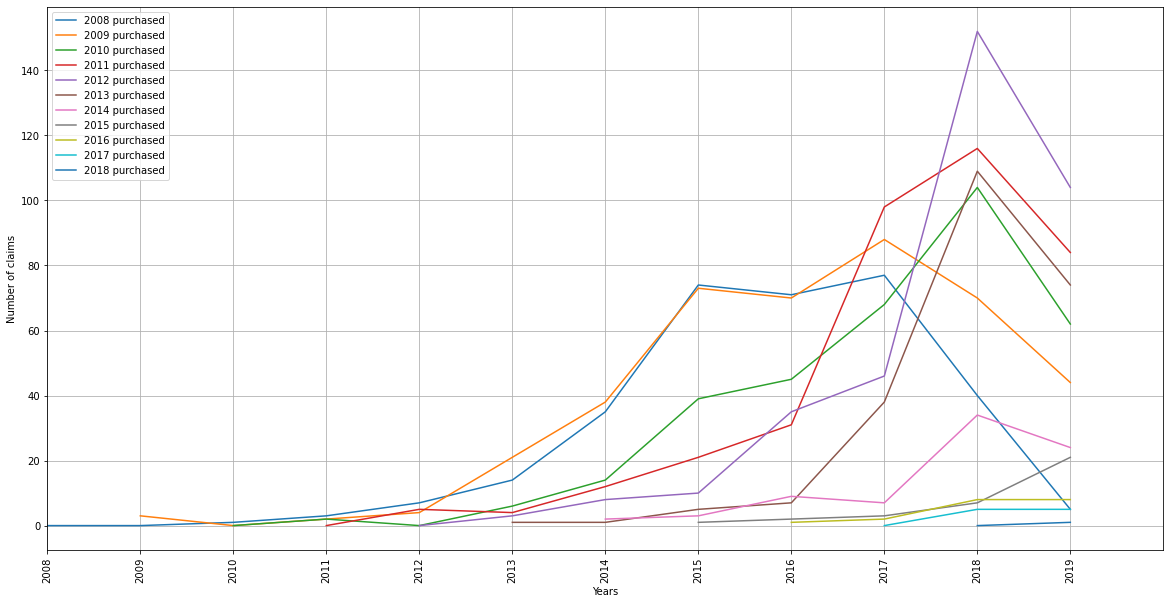

In [428]:
# distribution of claims from manufacturing year for next 10 years from 2000 manufacturing year
start_year=2008
end_year=2018
import matplotlib as mpl

n=len(range(start_year,end_year+1))
colors = mpl.cm.rainbow(np.linspace(0, 1, n))
fig, ax = plt.subplots(figsize=(20,10))


for y in range(start_year,end_year+1):
    #ignore column Total
    s=clean_data2.loc[:, clean_data2.columns != 'Total']
    #get the columns where value >= y
    sel_col=[c for c in s.columns.tolist() if c>=y]
#     print('min year',min(sel_col))
    s=s[sel_col]
#     print('min year',min(sel_col),s.shape[1])
    s=s.loc[y,:]
    
    plt.plot(s.index,s.values,label='%s purchased' % y )
    #plt.label(y)
    plt.xlim(start_year,end_year+2)
    plt.xticks(list(range(start_year,end_year+2)),rotation=90)

    
#     break
plt.legend()    
plt.xlabel('Years')
plt.ylabel('Number of claims')
plt.grid()
plt.show()
    
    
    

#### Moving window distribution plot purchase claim

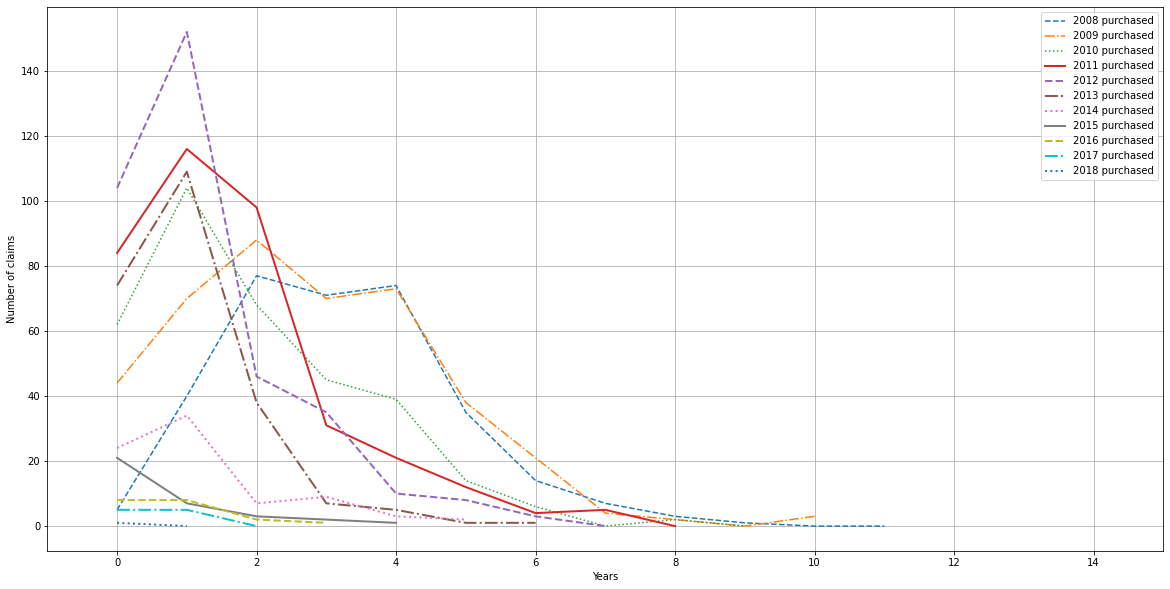

In [429]:
# distribution of claims from manufacturing year for next 10 years from 2000 manufacturing year
start_year=2008
end_year=2018
import matplotlib as mpl
clean_data2=clean_data_pur_cl.copy()

n=len(range(start_year,end_year+1))
colors = mpl.cm.rainbow(np.linspace(0, 1, n))
fig, ax = plt.subplots(figsize=(20,10))

linestyles = ['-', '--', '-.', ':']
#markers=['1','2','3','4','5']
linewidth=1.5

j=0
for y in range(start_year,end_year+1):
    j=j+1
    if j>=len(linestyles):
        j=0
        linewidth=2
    #ignore column Total
    s=clean_data2.loc[:, clean_data2.columns != 'Total']
    #get the columns where value >= y
    sel_col=[c for c in s.columns.tolist() if c>=y]
#     print('min year',min(sel_col))
    s=s[sel_col]
#     print(y,s.columns)
#     print('min year',min(sel_col),s.shape[1])
    s=s.loc[y,:]
#     print(type(s),s.index)
    s.reset_index(drop=True, inplace=True)
#     print(type(s),s.index,s.values)
    #plt.plot(s.index,s.values,label='%s purchased' % y )
    plt.plot(s.index,s.values,label='%s purchased' % y,linestyle=linestyles[j],linewidth=linewidth )
    #plt.xlim(start_year,end_year+2)
    plt.xlim(-1,15)
    #plt.xticks(list(range(start_year,end_year+2)),rotation=90)

    
#     break
plt.legend()    
plt.xlabel('Years')
plt.ylabel('Number of claims')
plt.grid()
plt.show()
    
    
    

#### Moving window dist plot purchase square

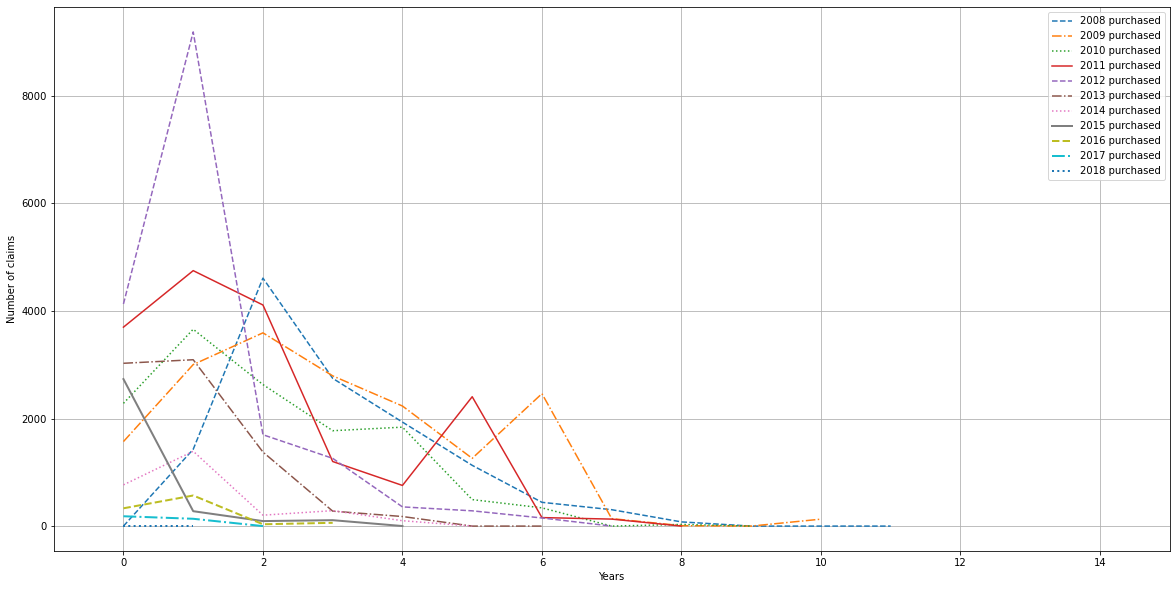

In [430]:
# distribution of claims from manufacturing year for next 10 years from 2000 manufacturing year
start_year=2008
end_year=2018
import matplotlib as mpl
clean_data2=clean_data_pur_sq.copy()
linestyles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted']

n=len(range(start_year,end_year+1))
colors = mpl.cm.rainbow(np.linspace(0, 1, n))
fig, ax = plt.subplots(figsize=(20,10))
j=0
linewidth=1.5
for y in range(start_year,end_year+1):
    j=j+1
    if j>=len(linestyles):
        j=0
        linewidth=2
    #ignore column Total
    s=clean_data2.loc[:, clean_data2.columns != 'Total']
    #get the columns where value >= y
    sel_col=[c for c in s.columns.tolist() if c>=y]
#     print('min year',min(sel_col))
    s=s[sel_col]
    s=s.loc[y,:]
    s.reset_index(drop=True, inplace=True)
    plt.plot(s.index,s.values,label='%s purchased' % y ,linestyle=linestyles[j],linewidth=linewidth)
    plt.xlim(-1,15)

    plt.legend()    
plt.xlabel('Years')
plt.ylabel('Number of claims')
plt.grid()
plt.show()
    
    
    

In [431]:
from matplotlib import lines
lines.lineStyles.keys()

dict_keys(['-', '--', '-.', ':', 'None', ' ', ''])

#### Moving window dist plot mfg claim

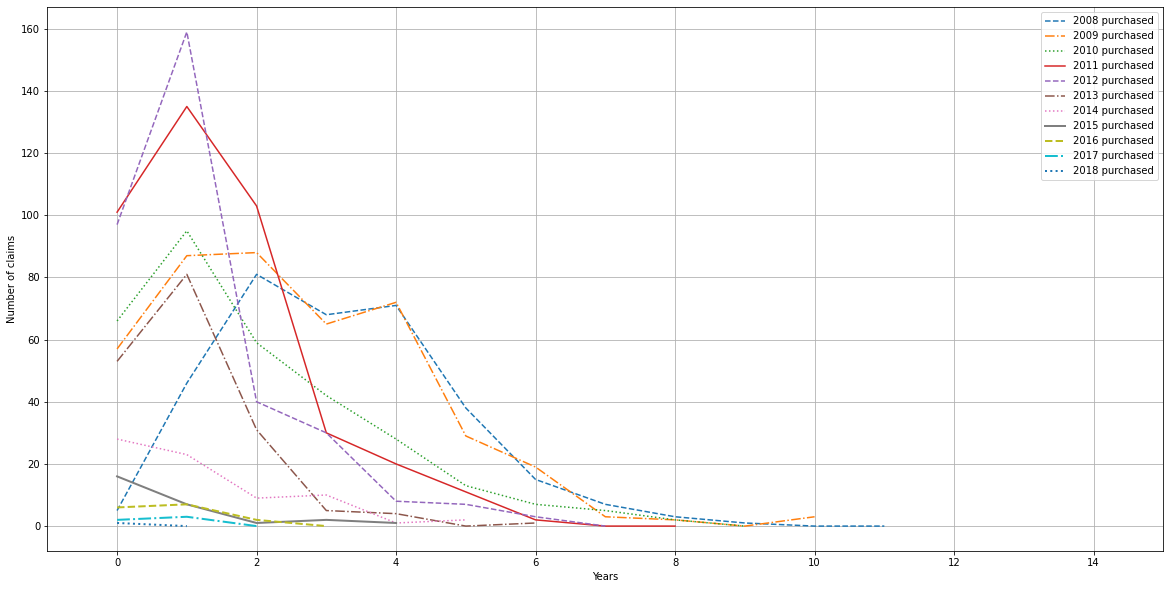

In [432]:
# distribution of claims from manufacturing year for next 10 years from 2000 manufacturing year
start_year=2008
end_year=2018
import matplotlib as mpl
clean_data2=clean_data_mfg_cl.copy()
linestyles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted']

n=len(range(start_year,end_year+1))
colors = mpl.cm.rainbow(np.linspace(0, 1, n))
fig, ax = plt.subplots(figsize=(20,10))
j=0
linewidth=1.5
for y in range(start_year,end_year+1):
    j=j+1
    if j>=len(linestyles):
        j=0
        linewidth=2
    #ignore column Total
    s=clean_data2.loc[:, clean_data2.columns != 'Total']
    #get the columns where value >= y
    sel_col=[c for c in s.columns.tolist() if c>=y]
#     print('min year',min(sel_col))
    s=s[sel_col]
#     print(y,s.columns)
#     print('min year',min(sel_col),s.shape[1])
    s=s.loc[y,:]
#     print(type(s),s.index)
    s.reset_index(drop=True, inplace=True)
#     print(type(s),s.index,s.values)
    #plt.plot(s.index,s.values,label='%s purchased' % y )
    plt.plot(s.index,s.values,label='%s purchased' % y ,linestyle=linestyles[j],linewidth=linewidth)
    #plt.xlim(start_year,end_year+2)
    plt.xlim(-1,15)
    #plt.xticks(list(range(start_year,end_year+2)),rotation=90)

    
#     break
plt.legend()    
plt.xlabel('Years')
plt.ylabel('Number of claims')
plt.grid()
plt.show()
    
    
    

#### Moving window dist plot mfg square

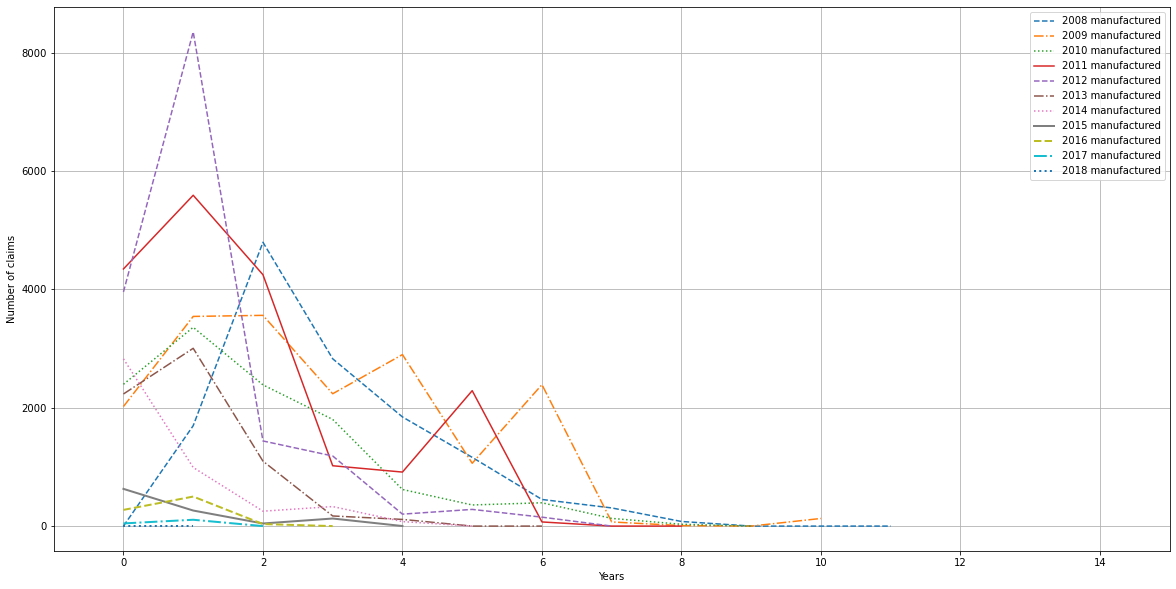

In [433]:
# distribution of claims from manufacturing year for next 10 years from 2000 manufacturing year
dist_start_year=2008
dist_end_year=2018
import matplotlib as mpl
clean_data2=clean_data_mfg_sq.copy()
linestyles = ['-', '--', '-.', ':', 'solid', 'dashed', 'dashdot', 'dotted']

n=len(range(start_year,end_year+1))
colors = mpl.cm.rainbow(np.linspace(0, 1, n))
fig, ax = plt.subplots(figsize=(20,10))

j=0
linewidth=1.5
for y in range(dist_start_year,dist_end_year+1):
    j=j+1
    if j>=len(linestyles):
        j=0
        linewidth=2
    #ignore column Total
    s=clean_data2.loc[:, clean_data2.columns != 'Total']
    #get the columns where value >= y
    sel_col=[c for c in s.columns.tolist() if c>=y]
#     print('min year',min(sel_col))
    s=s[sel_col]
#     print(y,s.columns)
#     print('min year',min(sel_col),s.shape[1])
    s=s.loc[y,:]
#     print(type(s),s.index)
    s.reset_index(drop=True, inplace=True)
#     print(type(s),s.index,s.values)
    #plt.plot(s.index,s.values,label='%s purchased' % y )
    plt.plot(s.index,s.values,label='%s manufactured' % y,linestyle=linestyles[j],linewidth=linewidth )
    #plt.xlim(start_year,end_year+2)
    plt.xlim(-1,15)
    #plt.xticks(list(range(start_year,end_year+2)),rotation=90)

    
#     break
plt.legend()    
plt.xlabel('Years')
plt.ylabel('Number of claims')
plt.grid()
plt.show()
    
    
    

## Simulation and forcasting

In [461]:
# drop Total row and Total column
#clean_data_mfg_sq.drop(['Total'],axis=0,inplace=True)
#clean_data_mfg_sq.drop(['Total'],axis=1,inplace=True)
#clean_data_mfg_sq.loc[end_year:start_year]  #:start_year]
#clean_data_mfg_sq[(clean_data_mfg_sq.index>=start_year) & (clean_data_mfg_sq.index<=end_year)]
#clean_data_mfg_sq
#clean_data_mfg_sq_new.drop([2010,2009,2008,'Total'],axis=1,inplace=True)
#drop_col
clean_data_mfg_sq

RecvdDt_Y,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,Total
MfgDate_Y,,,,,,,,,,,,,
2018,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00
2017,45.0,107.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,152.00
2016,274.0,499.0,34.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,807.00
2015,629.0,263.0,44.0,128.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1065.00
2014,2827.0,991.0,252.0,330.0,76.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,4476.00
2013,2233.0,3005.0,1098.0,171.0,113.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,6620.00
2012,3958.0,8353.0,1439.0,1185.0,202.0,282.0,151.00,0.0,0.0,0.0,0.0,0.0,15570.00
2011,4346.0,5592.0,4249.0,1020.0,913.0,2289.0,70.00,0.0,0.0,0.0,0.0,0.0,18479.00
2010,2397.0,3360.0,2387.0,1803.0,619.0,357.0,394.00,130.0,31.0,0.0,0.0,0.0,11478.00


In [472]:
print(clean_data_mfg_sq.head(2))
start_year_mfg=2011
end_year_mfg=2017
start_year_claim=2011
end_year_claim=2019

clean_data_mfg_sq_new=clean_data_mfg_sq.copy()

# drop Total row and Total column
clean_data_mfg_sq_new.drop(['Total'],axis=0,inplace=True)
clean_data_mfg_sq_new.drop(['Total'],axis=1,inplace=True)

#get data  between start_year_mfg and end_year_mfg
clean_data_mfg_sq_new=clean_data_mfg_sq_new[(clean_data_mfg_sq_new.index>=start_year_mfg) & (clean_data_mfg_sq_new.index<=end_year_mfg)]

#keep columns between start_year_claim and end_year_claim
drop_col=clean_data_mfg_sq_new.columns.tolist()
drop_col=[i for i in drop_col if i<start_year_claim or i > end_year_claim]
clean_data_mfg_sq_new.drop(drop_col,axis=1,inplace=True)
clean_data_mfg_sq_new

RecvdDt_Y  2019   2018  2017  2016  2015  2014  2013  2012  2011  2010  2009  \
MfgDate_Y                                                                      
2018        0.0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2017       45.0  107.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

RecvdDt_Y  2008  Total  
MfgDate_Y               
2018        0.0    0.0  
2017        0.0  152.0  


RecvdDt_Y,2019,2018,2017,2016,2015,2014,2013,2012,2011
MfgDate_Y,,,,,,,,,
2017,45.0,107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016,274.0,499.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0
2015,629.0,263.0,44.0,128.0,1.0,0.0,0.0,0.0,0.0
2014,2827.0,991.0,252.0,330.0,76.0,0.0,0.0,0.0,0.0
2013,2233.0,3005.0,1098.0,171.0,113.0,0.0,0.0,0.0,0.0
2012,3958.0,8353.0,1439.0,1185.0,202.0,282.0,151.0,0.0,0.0
2011,4346.0,5592.0,4249.0,1020.0,913.0,2289.0,70.0,0.0,0.0


In [473]:
#shift moving windows. assuming claim year from 2011, 2012 shift by 1, 2013 by 2 so on manual 
j=1
for i in range(start_year_mfg+1,end_year_mfg+1):
    #print(i)
    clean_data_mfg_sq_new.loc[i]=clean_data_mfg_sq_new.loc[i].shift(j)
    j=j+1
clean_data_mfg_sq_new

RecvdDt_Y,2019,2018,2017,2016,2015,2014,2013,2012,2011
MfgDate_Y,,,,,,,,,
2017,NaN,NaN,NaN,NaN,NaN,NaN,45.0,107.0,0.0
2016,NaN,NaN,NaN,NaN,NaN,274.0,499.0,34.0,0.0
2015,NaN,NaN,NaN,NaN,629.0,263.0,44.0,128.0,1.0
2014,NaN,NaN,NaN,2827.0,991.0,252.0,330.0,76.0,0.0
2013,NaN,NaN,2233.0,3005.0,1098.0,171.0,113.0,0.0,0.0
2012,NaN,3958.0,8353.0,1439.0,1185.0,202.0,282.0,151.0,0.0
2011,4346.0,5592.0,4249.0,1020.0,913.0,2289.0,70.0,0.0,0.0


In [474]:
# sort columns in ascending order of clain year
clean_data_mfg_sq_new=clean_data_mfg_sq_new[sorted(clean_data_mfg_sq_new.columns.tolist())]

#rename columns with 0,1,2... as time window instead of claim year. n represent nth year after manufacturing 
clean_data_mfg_sq_new.columns=range(0,len(clean_data_mfg_sq_new.columns))

# no of years to calculate effect of warranty max
warranty=15
# add timewindows 9 to 14. as we dont have data from timewindow starting from 9
for i in range(len(clean_data_mfg_sq_new.columns),warranty):
    clean_data_mfg_sq_new[i]=np.nan


In [475]:
clean_data_mfg_sq_new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
MfgDate_Y,,,,,,,,,,,,,,,
2017,0.0,107.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,0.0,34.0,499.0,274.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,1.0,128.0,44.0,263.0,629.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,0.0,76.0,330.0,252.0,991.0,2827.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,0.0,0.0,113.0,171.0,1098.0,3005.0,2233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,0.0,151.0,282.0,202.0,1185.0,1439.0,8353.0,3958.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,0.0,0.0,70.0,2289.0,913.0,1020.0,4249.0,5592.0,4346.0,NaN,NaN,NaN,NaN,NaN,NaN


In [476]:
# forcase missing nan values for each mfg year by regression
from sklearn.linear_model import LinearRegression
# min no of history data required to forcast
no_of_hist_req=5
for i in clean_data_mfg_sq_new.index.tolist():
    #select a row from DF. i.e for single MFG year
    temp=clean_data_mfg_sq_new.loc[i]
    if temp.shape[0]-temp.isna().sum() >=no_of_hist_req:
        na=temp.isna().sum()
        print('for year',i,' history data shape',temp.shape[0]-temp.isna().sum(),' no of pred to made ',na)
        #no of datapoints availble
        h1=temp.shape[0]-na+1
        y=np.array(temp[:h1-1])
        x=np.array(list(range(1,h1)))
        #future x values
        f=np.array(list(range(h1,h1+na)))
        print(' history x',x, ' history y ',y,' future x',f)
        reg = LinearRegression().fit(x.reshape(-1, 1),y.reshape(-1, 1))
        print('coeff and intercept',reg.coef_,reg.intercept_)
        clean_data_mfg_sq_new.loc[i,h1-1:]=np.round(reg.predict(f.reshape(-1, 1)).reshape(na),0)
        
clean_data_mfg_sq_new

for year 2015  history data shape 5  no of pred to made  10
 history x [1 2 3 4 5]  history y  [  1. 128.  44. 263. 629.]  future x [ 6  7  8  9 10 11 12 13 14 15]
coeff and intercept [[139.1]] [-204.3]
for year 2014  history data shape 6  no of pred to made  9
 history x [1 2 3 4 5 6]  history y  [   0.   76.  330.  252.  991. 2827.]  future x [ 7  8  9 10 11 12 13 14 15]
coeff and intercept [[480.05714286]] [-934.2]
for year 2013  history data shape 7  no of pred to made  8
 history x [1 2 3 4 5 6 7]  history y  [   0.    0.  113.  171. 1098. 3005. 2233.]  future x [ 8  9 10 11 12 13 14 15]
coeff and intercept [[489.07142857]] [-1010.57142857]
for year 2012  history data shape 8  no of pred to made  7
 history x [1 2 3 4 5 6 7 8]  history y  [   0.  151.  282.  202. 1185. 1439. 8353. 3958.]  future x [ 9 10 11 12 13 14 15]
coeff and intercept [[871.07142857]] [-1973.57142857]
for year 2011  history data shape 9  no of pred to made  6
 history x [1 2 3 4 5 6 7 8 9]  history y  [   0. 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
MfgDate_Y,,,,,,,,,,,,,,,
2017,0.0,107.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,0.0,34.0,499.0,274.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,1.0,128.0,44.0,263.0,629.0,630.0,769.0,908.0,1048.0,1187.0,1326.0,1465.0,1604.0,1743.0,1882.0
2014,0.0,76.0,330.0,252.0,991.0,2827.0,2426.0,2906.0,3386.0,3866.0,4346.0,4826.0,5307.0,5787.0,6267.0
2013,0.0,0.0,113.0,171.0,1098.0,3005.0,2233.0,2902.0,3391.0,3880.0,4369.0,4858.0,5347.0,5836.0,6326.0
2012,0.0,151.0,282.0,202.0,1185.0,1439.0,8353.0,3958.0,5866.0,6737.0,7608.0,8479.0,9350.0,10221.0,11093.0
2011,0.0,0.0,70.0,2289.0,913.0,1020.0,4249.0,5592.0,4346.0,5491.0,6178.0,6866.0,7553.0,8241.0,8928.0


In [477]:
# calculate parameter of triangular distribution
percentile=.75
# calculated from given percentile. This should be done together before creating rows
b=clean_data_mfg_sq_new.quantile(percentile,axis=0)
a=clean_data_mfg_sq_new.min(axis=0)
c=clean_data_mfg_sq_new.max(axis=0)

clean_data_mfg_sq_new.loc['a',:]=a
clean_data_mfg_sq_new.loc['b',:]=b
clean_data_mfg_sq_new.loc['c',:]=c
clean_data_mfg_sq_new
#clean_data2.loc['Total',:]= clean_data2.sum(axis=0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
MfgDate_Y,,,,,,,,,,,,,,,
2017,0.0,107.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016,0.0,34.0,499.0,274.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,1.0,128.0,44.0,263.00,629.0,630.0,769.0,908.0,1048.0,1187.0,1326.0,1465.0,1604.0,1743.0,1882.0
2014,0.0,76.0,330.0,252.00,991.0,2827.0,2426.0,2906.0,3386.0,3866.0,4346.0,4826.0,5307.0,5787.0,6267.0
2013,0.0,0.0,113.0,171.00,1098.0,3005.0,2233.0,2902.0,3391.0,3880.0,4369.0,4858.0,5347.0,5836.0,6326.0
2012,0.0,151.0,282.0,202.00,1185.0,1439.0,8353.0,3958.0,5866.0,6737.0,7608.0,8479.0,9350.0,10221.0,11093.0
2011,0.0,0.0,70.0,2289.00,913.0,1020.0,4249.0,5592.0,4346.0,5491.0,6178.0,6866.0,7553.0,8241.0,8928.0
a,0.0,0.0,44.0,171.00,629.0,630.0,769.0,908.0,1048.0,1187.0,1326.0,1465.0,1604.0,1743.0,1882.0
b,0.0,117.5,306.0,271.25,1098.0,2827.0,4249.0,3958.0,4346.0,5491.0,6178.0,6866.0,7553.0,8241.0,8928.0


In [384]:
#np.percentile(np.array([70,282,113,330,44,499,45]), 75)

306.0

In [478]:
# calculate simulation of triangular dist
no_years=50
ran_mat=np.random.rand(no_years,warranty)
sq_singles=np.zeros((no_years,warranty))

In [479]:
# calculate squares values by inverse triangular CDF function
#for each row 
for i in range(sq_singles.shape[0]):
    #for each column
    for j in range(sq_singles.shape[1]):
        #print(i,j,clean_data_mfg_sq_new.loc['a'][j],clean_data_mfg_sq_new.loc['b'][j],clean_data_mfg_sq_new.loc['c'][j])
        #print(sq_singles[i][j])
        if ran_mat[i][j] <= (clean_data_mfg_sq_new.loc['b'][j]-clean_data_mfg_sq_new.loc['a'][j])/(clean_data_mfg_sq_new.loc['c'][j]-clean_data_mfg_sq_new.loc['a'][j]):
            sq_singles[i][j]=clean_data_mfg_sq_new.loc['a'][j] + math.sqrt(ran_mat[i][j]*(clean_data_mfg_sq_new.loc['c'][j]-clean_data_mfg_sq_new.loc['a'][j])*(clean_data_mfg_sq_new.loc['b'][j]-clean_data_mfg_sq_new.loc['a'][j]))
        else:
            sq_singles[i][j]==clean_data_mfg_sq_new.loc['b'][j]-math.sqrt((1-ran_mat[i][j])*(clean_data_mfg_sq_new.loc['c'][j]-clean_data_mfg_sq_new.loc['a'][j])*(clean_data_mfg_sq_new.loc['c'][j]-clean_data_mfg_sq_new.loc['b'][j]))
        
sq_singles[0:2]

array([[   0.        ,    0.        ,    0.        ,    0.        ,
         741.73678524, 2806.37164192, 2869.75720242, 3912.84822119,
        3592.22812559, 4581.57997062, 4780.93400394,    0.        ,
        5342.75950885,    0.        , 4534.5804457 ],
       [   0.        ,   76.58960387,    0.        ,    0.        ,
         998.19303331, 1716.96121124, 3953.59565277, 2274.93951493,
           0.        , 5037.42052286, 4816.13841305, 5243.5213613 ,
        4324.93476927, 8123.72454689, 6782.66826845]])

In [480]:
# mfg unit in 2011
mfg_2011=30000000
#mfg growth rate (its assumned same as NPV)
annual_discount_rate=.01

mfg_sq=np.array(range(no_years))
for i in range(no_years):
    #formula assumed for mfg growth
    mfg_sq[i]=mfg_2011*(1+annual_discount_rate)**mfg_sq[i]

# create factor for each mfg year considering growth
factor=np.ones((no_years))
for i in range(no_years):
    factor[i]=mfg_sq[i]/mfg_sq[0]

#initialize sq_singles_adj    
sq_singles_adj=np.zeros((no_years,warranty))

#adjusted simulated square by multiplying a factor for each mfg year 
for i in range(no_years):
    sq_singles_adj[i]=sq_singles[i]*factor[i]
    
sq_singles_adj[0:2]    

array([[   0.        ,    0.        ,    0.        ,    0.        ,
         741.73678524, 2806.37164192, 2869.75720242, 3912.84822119,
        3592.22812559, 4581.57997062, 4780.93400394,    0.        ,
        5342.75950885,    0.        , 4534.5804457 ],
       [   0.        ,   77.35549991,    0.        ,    0.        ,
        1008.17496364, 1734.13082336, 3993.13160929, 2297.68891008,
           0.        , 5087.79472809, 4864.29979718, 5295.95657492,
        4368.18411697, 8204.96179236, 6850.49495114]])

In [481]:
# average cost per singles
# initial value of per shingles $ cost in 2011
avg_cost_shingles_2011=17
#an estimate inflation value considering last few years max value
cagr=.0218
no_years_cagr=no_years+warranty
t=np.array(range(no_years_cagr))
cagr_2=np.zeros((no_years_cagr,1))

for i in range(no_years_cagr):
    cagr_2[i]=round(avg_cost_shingles_2011*(1+cagr)**t[i],1)

cagr_2=cagr_2.reshape(no_years_cagr)    

#create inflation matrix for 50*15 size staring from 2011 mfg year
inflation_mat=np.zeros((no_years,warranty))

k=0
for i in range(no_years):
    k=i
    for j in range(15):
        inflation_mat[i,j]=cagr_2[k]
        k=k+1

#calculate singles in USD
sq_singles_usd=np.zeros((no_years,warranty))
sq_singles_usd=sq_singles_adj*inflation_mat
print(sq_singles_adj[:2])
print(inflation_mat[:2])
sq_singles_usd[:2]  # This is SHINGLES IN USD $ in excel

[[   0.            0.            0.            0.          741.73678524
  2806.37164192 2869.75720242 3912.84822119 3592.22812559 4581.57997062
  4780.93400394    0.         5342.75950885    0.         4534.5804457 ]
 [   0.           77.35549991    0.            0.         1008.17496364
  1734.13082336 3993.13160929 2297.68891008    0.         5087.79472809
  4864.29979718 5295.95657492 4368.18411697 8204.96179236 6850.49495114]]
[[17.  17.4 17.7 18.1 18.5 18.9 19.3 19.8 20.2 20.6 21.1 21.6 22.  22.5
  23. ]
 [17.4 17.7 18.1 18.5 18.9 19.3 19.8 20.2 20.6 21.1 21.6 22.  22.5 23.
  23.5]]


array([[     0.        ,      0.        ,      0.        ,
             0.        ,  13722.13052694,  53040.42403236,
         55386.31400673,  77474.39477952,  72563.00813687,
         94380.54739479, 100877.70748308,      0.        ,
        117540.70919479,      0.        , 104295.35025099],
       [     0.        ,   1369.19234842,      0.        ,
             0.        ,  19054.50681286,  33468.72489076,
         79064.00586399,  46413.31598356,      0.        ,
        107352.46876276, 105068.87561912, 116511.04464815,
         98284.14263172, 188714.12122424, 160986.63135169]])

In [482]:
sq_singles.shape
npv_rate=.01
#compare_years for waranty
compare_year_1=10
compare_year_2=15


# calculate NPV for next 10 years for a single mfg year
npv_year=compare_year_1
npv_usd=np.zeros(no_years)
for i in range(no_years):
    npv_usd[i]=np.npv(npv_rate,sq_singles_usd[i][:npv_year])
npv_usd_10=npv_usd.copy()

# calculate NPV for 15 years for a single mfg year
npv_year=compare_year_2
npv_usd=np.zeros(no_years)
for i in range(no_years):
    npv_usd[i]=np.npv(npv_rate,sq_singles_usd[i][:npv_year])
npv_usd_15=npv_usd.copy()

# calculate squares for 10 years
y=compare_year_1
t=sq_singles[:,0:y]
print(t.shape)
Claim_Sq_10yrs=np.zeros(no_years)
Claim_Sq_10yrs=t.sum(axis=1)
Claim_Sq_10yrs

# calculate squares for 15 years
y=compare_year_2
t=sq_singles[:,0:y]
print(t.shape)
Claim_Sq_15yrs=np.zeros(no_years)
Claim_Sq_15yrs=t.sum(axis=1)
Claim_Sq_15yrs


# average price of shingles
Avg_per_shingle_10yrs=npv_usd_15/Claim_Sq_15yrs
Avg_per_shingle_15yrs=npv_usd_10/Claim_Sq_10yrs

Avg_per_shingle_15yrs


#calculate difference_usd
DIFFERENCE_USD=npv_usd_15-npv_usd_10
DIFFERENCE_USD

DIFFERENCE_SQ=Claim_Sq_15yrs-Claim_Sq_10yrs
DIFFERENCE_SQ

(50, 10)
(50, 15)


array([14658.27395849, 29290.98735897, 32245.37808748, 29680.09949625,
       17764.35682912,  3973.51186558, 18654.82214756, 24415.34420491,
       20324.83249678, 22157.16132927, 26351.21594733, 16188.36550685,
       19828.10875179, 26478.84920046, 26547.04849867, 10876.03667216,
       32693.99065778, 17206.78489916, 20366.16649379, 27165.19534988,
       19806.97146073, 19368.44029977, 18550.93645224,  9361.51192444,
       26298.3812271 , 19337.99851809, 19796.35289826, 18100.94175617,
       33132.5881427 , 24491.27840248,  8750.51583511, 25944.48296785,
       29534.99665149, 10765.0942023 , 20215.40472051, 22645.77689325,
       29962.56434769, 19251.92941372, 32279.54119044, 16008.7686636 ,
       33457.07187163, 18324.62273281, 21752.68030028, 18354.89816503,
       24377.43226094, 22926.04272271, 25476.7534417 , 20235.62345474,
       24431.02702252, 15972.24122846])

In [483]:
## Create output dataframe for storing
# mfg_sq
# DIFFERENCE_USD
# DIFFERENCE_SQ
# Claim_Sq_15yrs
# Claim_Sq_10yrs
# npv_usd_15
# npv_usd_10
# Avg_per_shingle_15yrs
# Avg_per_shingle_10yrs
#DIFF_RANKING=np.zeros(no_years)

DIFF_RANKING = np.argsort(np.argsort(DIFFERENCE_USD)) * 100. / (len(DIFFERENCE_USD) - 1)
#print(DIFFERENCE_USD)
DIFF_RANKING=np.round(DIFF_RANKING, 0)
DIFF_RANKING

try:
    i=np.where((DIFF_RANKING>=9) & (DIFF_RANKING<=11))[0][0]
    a=DIFF_RANKING[i]
except:
    print('No 9,10,11 percentile')
PERCENTILE_10_MM=DIFFERENCE_USD[i]

try:
    i=np.where((DIFF_RANKING>=89) & (DIFF_RANKING<=91))[0][0]
    b=DIFF_RANKING[i]
except:
    print('No 89,90,91 percentile')
PERCENTILE_90_MM=DIFFERENCE_USD[i]

#calculate expected value as .1*10th percentile+.9*90th percentile
Expected_value_Diff_MM_USD=round((PERCENTILE_10_MM*a/100+PERCENTILE_90_MM*b/100)/1000000,2)

print('Expected_value_Diff_MM_USD',Expected_value_Diff_MM_USD)

#manufacturing year start

year=np.array(list(range(start_year_mfg,start_year_mfg+no_years)))
#print(year)


Expected_value_Diff_MM_USD 1.72


In [489]:
df=pd.DataFrame({'mfg_year': year, 'npv_usd_10': npv_usd_10, 'npv_usd_15': npv_usd_15, 'DIFFERENCE_USD': DIFFERENCE_USD, 'DIFF_RANKING': DIFF_RANKING, 'mfg_sq': mfg_sq, 'Avg_per_shingle_10yrs': Avg_per_shingle_10yrs, 'Avg_per_shingle_15yrs': Avg_per_shingle_15yrs, 'Claim_Sq_10yrs': Claim_Sq_10yrs, 'Claim_Sq_15yrs': Claim_Sq_10yrs, 'DIFFERENCE_SQ': DIFFERENCE_SQ}, columns=['mfg_year', 'npv_usd_10', 'npv_usd_15', 'DIFFERENCE_USD', 'DIFF_RANKING', 'mfg_sq', 'Avg_per_shingle_10yrs', 'Avg_per_shingle_15yrs', 'Claim_Sq_10yrs', 'Claim_Sq_15yrs', 'DIFFERENCE_SQ'])
#df.value1 = df.value1.round()
c=['npv_usd_10', 'npv_usd_15', 'DIFFERENCE_USD',
       'DIFF_RANKING', 'mfg_sq',  'Claim_Sq_10yrs', 'Claim_Sq_15yrs',
       'DIFFERENCE_SQ']
decimals=0
for i in c:
    df[i] = df[i].apply(lambda x: round(x, decimals))
  
#c=['Avg_per_shingle_10yrs','Avg_per_shingle_15yrs']

df.head(2)

,mfg_year,npv_usd_10,npv_usd_15,DIFFERENCE_USD,DIFF_RANKING,mfg_sq,Avg_per_shingle_10yrs,Avg_per_shingle_15yrs,Claim_Sq_10yrs,Claim_Sq_15yrs,DIFFERENCE_SQ
0,2011,341398.0,627765.0,286368.0,2.0,30000000,18.929810,18.449417,18505.0,18505.0,14658.0
1,2012,267440.0,860080.0,592640.0,24.0,30300000,19.840965,19.024452,14058.0,14058.0,29291.0


In [413]:
np.where((DIFF_RANKING>=9) & (DIFF_RANKING<=11))[0][0]

#store in big query
#df.to_gbq(destination_table='warranty_claims.warranty_claims_output',project_id = 'gaf-np-ds',if_exists = 'replace')  #'replace')


4

In [ ]:
#

In [76]:
# clean_data2.index.tolist().min()
s

0        0.0
1     1428.0
2     4612.0
3     2748.0
4     1934.0
5     1130.0
6      442.0
7      305.0
8       78.0
9        0.0
10       0.0
11       0.0
Name: 2008, dtype: float64

#### purchase claim distribution

min year 2008


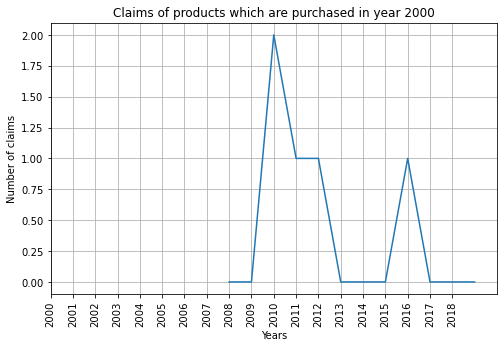

min year 2008


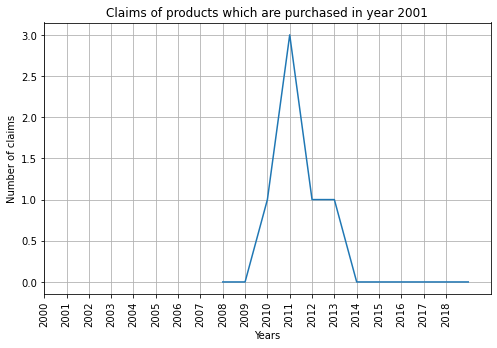

min year 2008


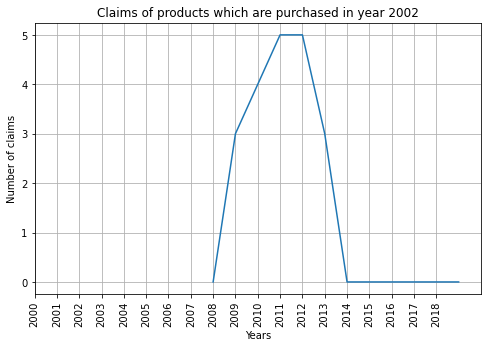

min year 2008


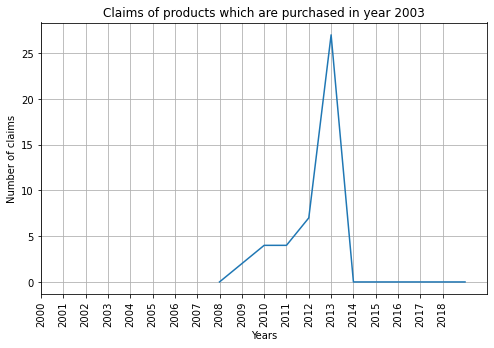

min year 2008


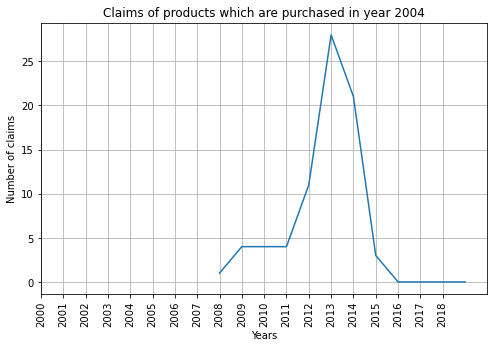

min year 2008


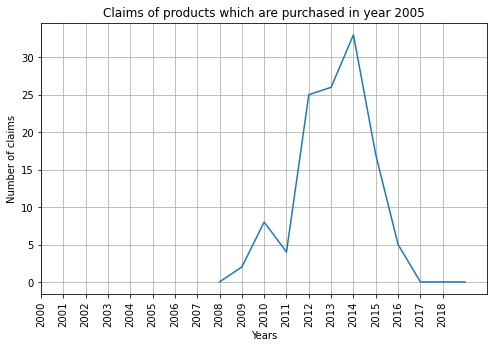

min year 2008


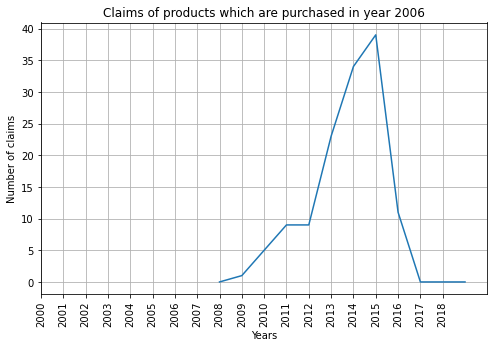

min year 2008


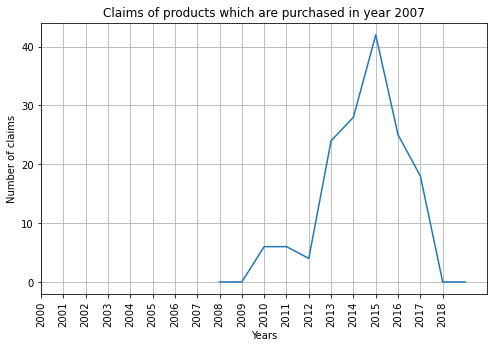

min year 2008


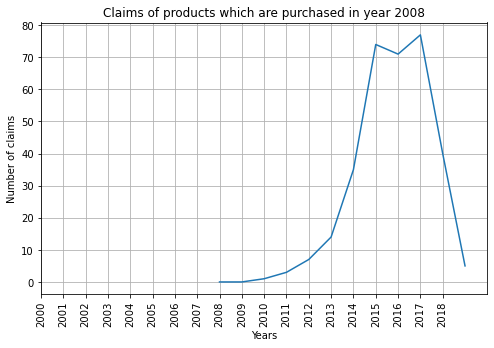

min year 2009


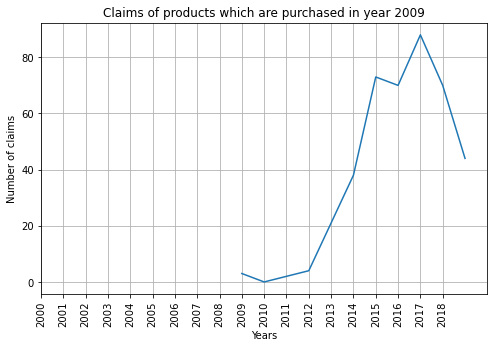

min year 2010


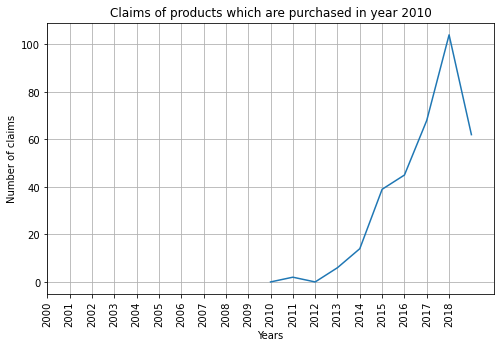

min year 2011


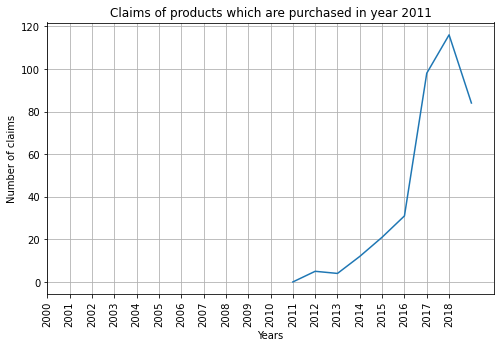

min year 2012


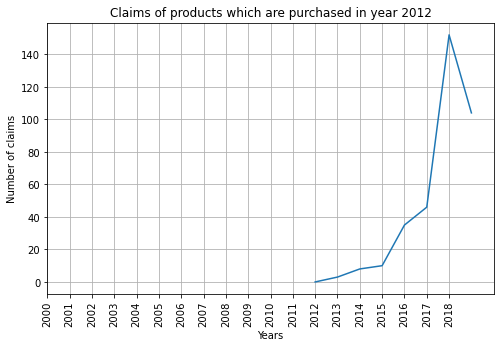

min year 2013


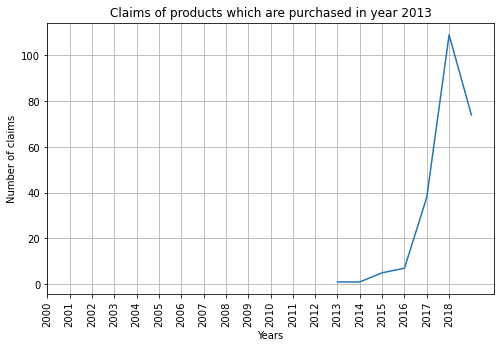

min year 2014


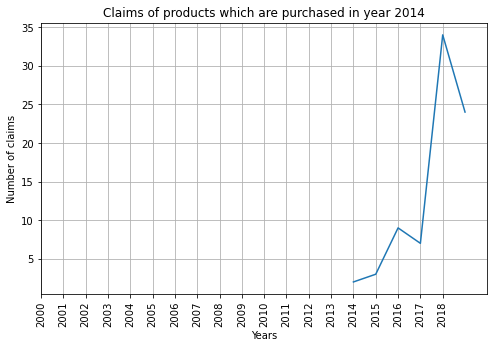

min year 2015


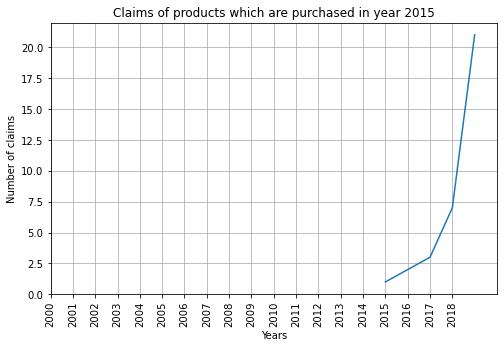

min year 2016


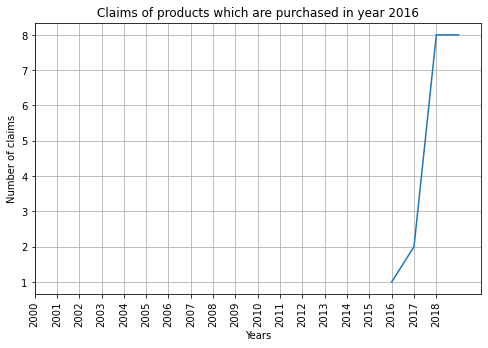

min year 2017


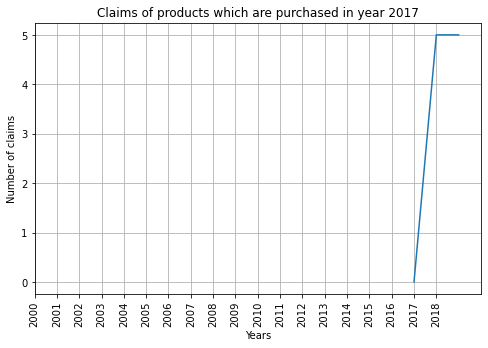

min year 2018


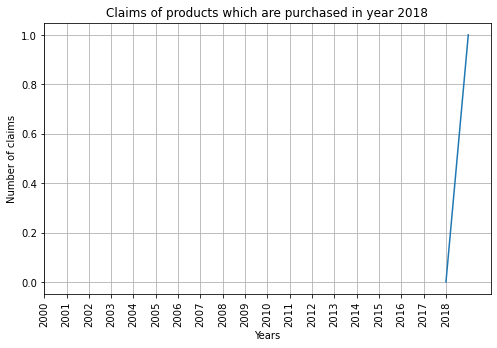

In [57]:
# distribution of claims from manufacturing year for next 10 years from 2000 manufacturing year
start_year=2000
end_year=2018
import matplotlib as mpl
clean_data2=clean_data_pur_cl.copy()

for y in range(start_year,end_year+1):
    fig, ax = plt.subplots(figsize=(8,5))
    #ignore column Total
    s=clean_data2.loc[:, clean_data2.columns != 'Total']
    #get the columns where value >= y
    sel_col=[c for c in s.columns.tolist() if c>=y]
    print('min year',min(sel_col))
    s=s[sel_col]
    #s=s.loc[y,clean_data2.columns != 'Total']
    s=s.loc[y,:]
    #print(s.index)
    plt.plot(s.index,s.values,label='HI')
    #plt.hist(s.index,s.values)  #, 3  ) #, alpha=0.5)  #, label='x')
    #plt.hist(s.values)  #,label='HI')
    plt.xlim(2000,2020)
    plt.title('Claims of products which are purchased in year '+str(y))
    plt.xticks(list(range(start_year,end_year+1)),rotation=90)
    plt.xlabel('Years')
    plt.ylabel('Number of claims')
    plt.grid()
    plt.show()
    #break    
    
    

#### Purchase squars dist

min year 2008


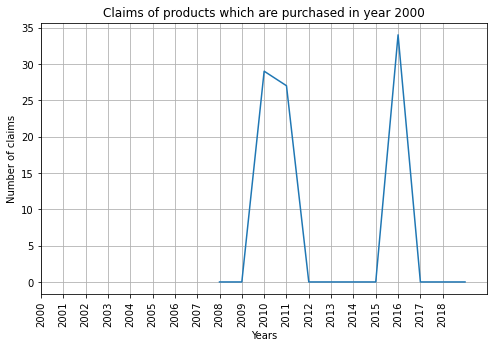

min year 2008


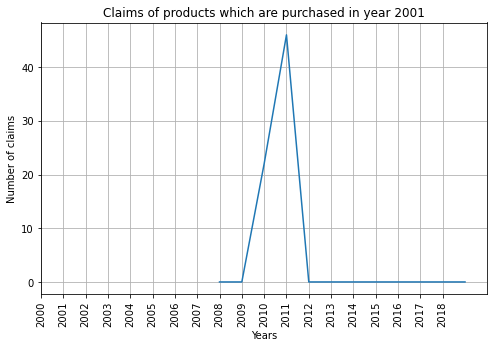

min year 2008


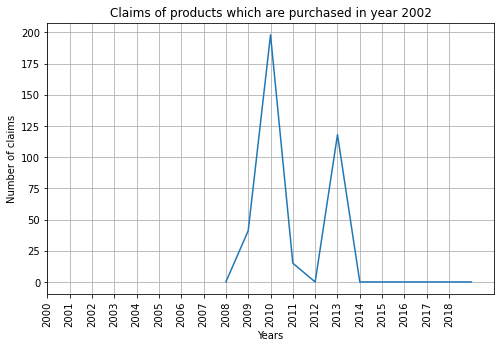

min year 2008


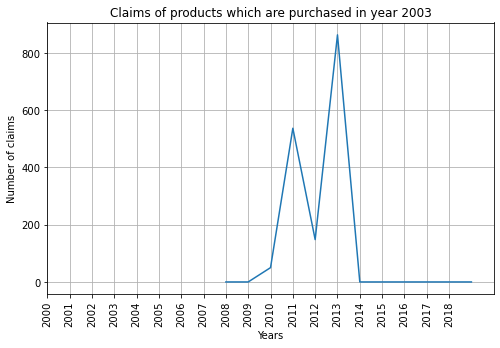

min year 2008


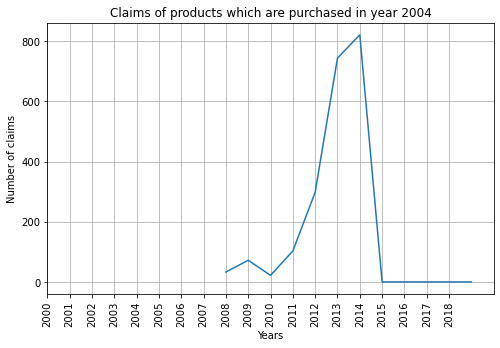

min year 2008


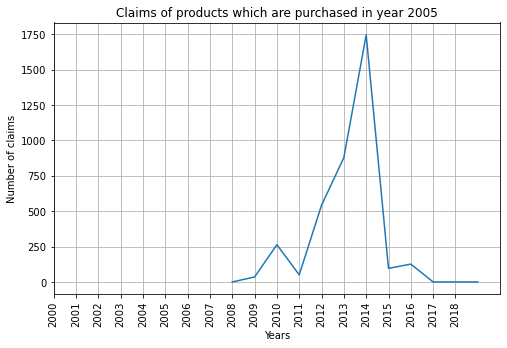

min year 2008


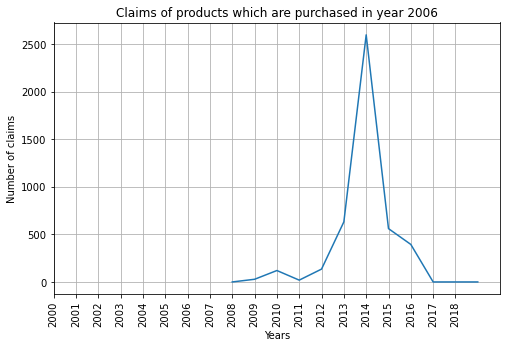

min year 2008


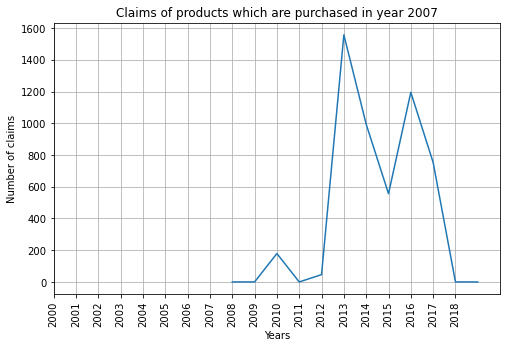

min year 2008


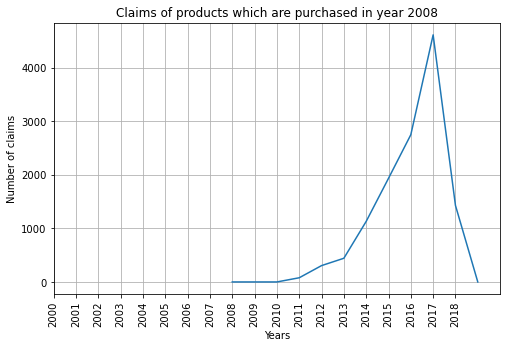

min year 2009


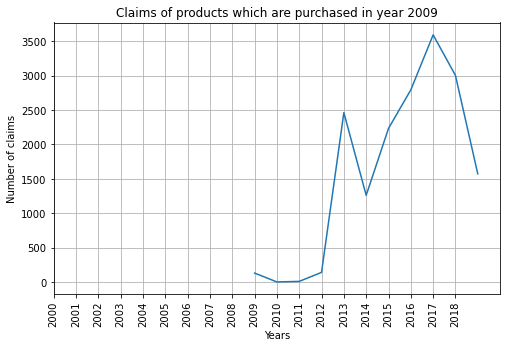

min year 2010


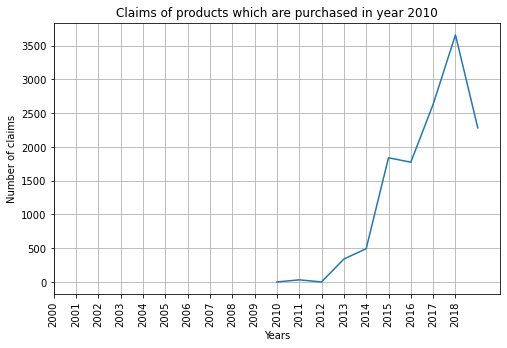

min year 2011


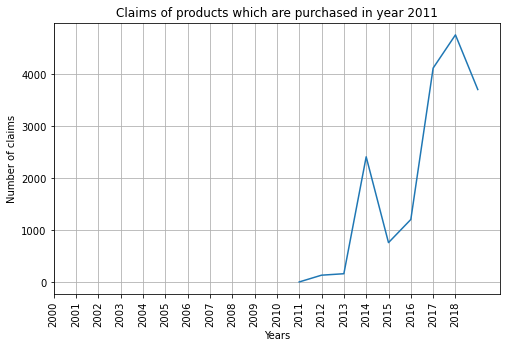

min year 2012


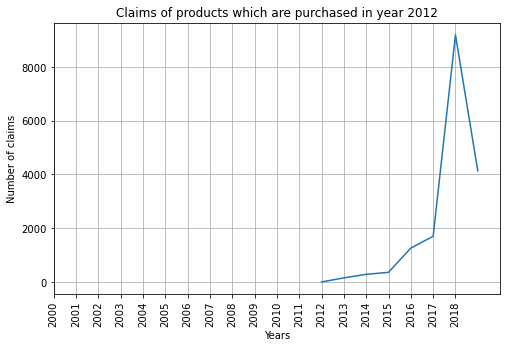

min year 2013


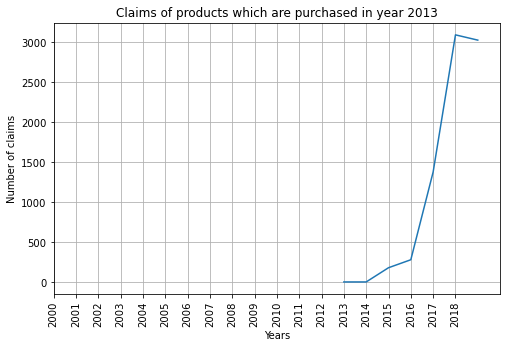

min year 2014


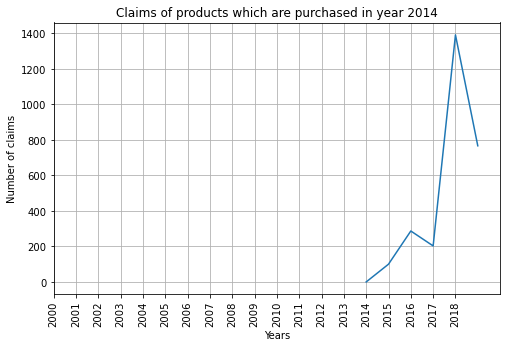

min year 2015


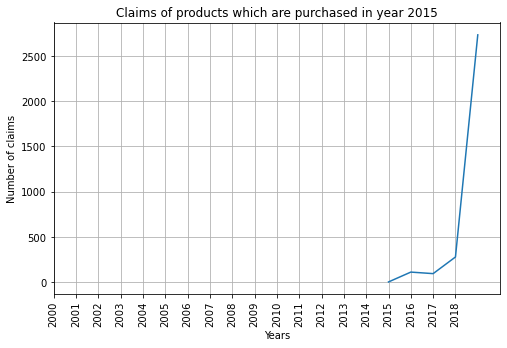

min year 2016


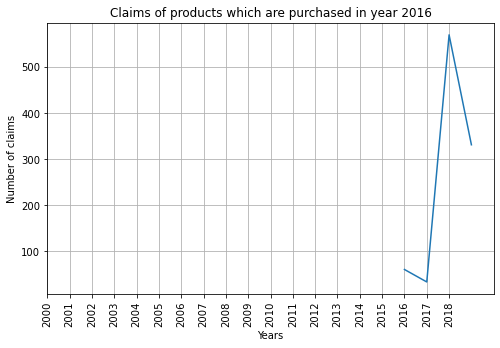

min year 2017


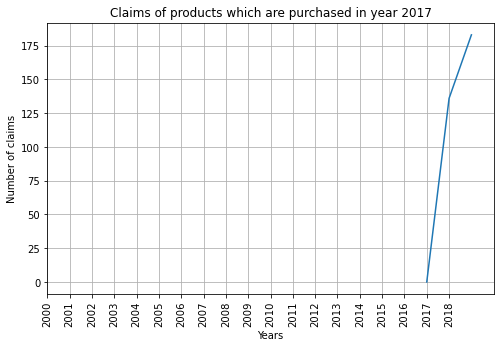

min year 2018


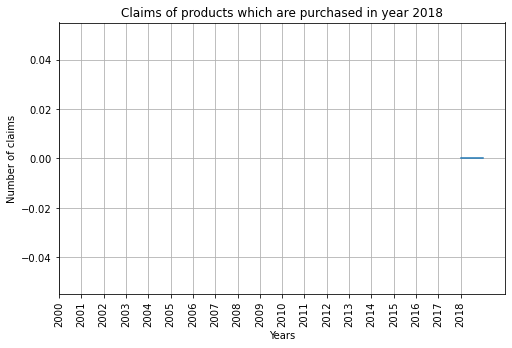

In [58]:
# distribution of claims from manufacturing year for next 10 years from 2000 manufacturing year
start_year=2000
end_year=2018
import matplotlib as mpl
clean_data2=clean_data_pur_sq.copy()

for y in range(start_year,end_year+1):
    fig, ax = plt.subplots(figsize=(8,5))
    #ignore column Total
    s=clean_data2.loc[:, clean_data2.columns != 'Total']
    #get the columns where value >= y
    sel_col=[c for c in s.columns.tolist() if c>=y]
    print('min year',min(sel_col))
    s=s[sel_col]
    #s=s.loc[y,clean_data2.columns != 'Total']
    s=s.loc[y,:]
    #print(s.index)
    plt.plot(s.index,s.values,label='HI')
    #plt.hist(s.index,s.values)  #, 3  ) #, alpha=0.5)  #, label='x')
    #plt.hist(s.values)  #,label='HI')
    plt.xlim(2000,2020)
    plt.title('Claims of products which are purchased in year '+str(y))
    plt.xticks(list(range(start_year,end_year+1)),rotation=90)
    plt.xlabel('Years')
    plt.ylabel('Number of claims')
    plt.grid()
    plt.show()
    #break    
    
    

#### mfg claim dist

min year 2008


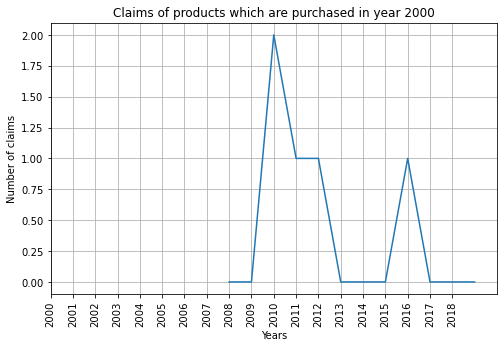

min year 2008


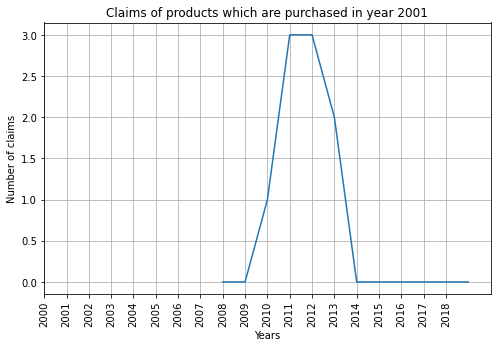

min year 2008


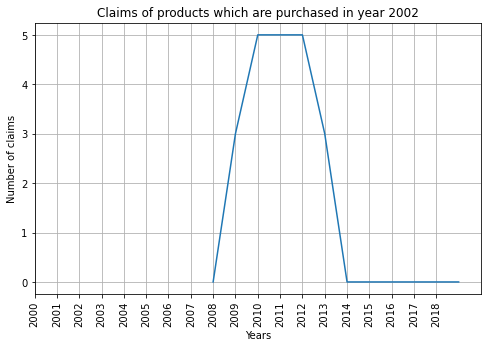

min year 2008


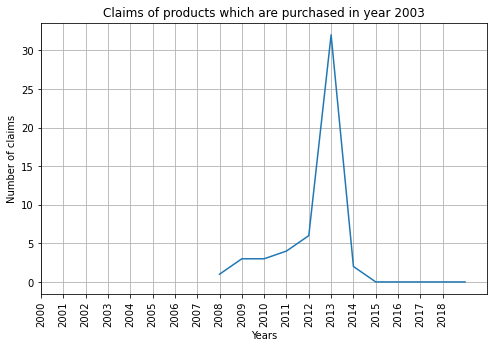

min year 2008


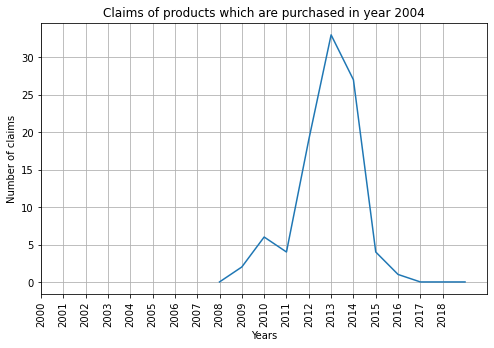

min year 2008


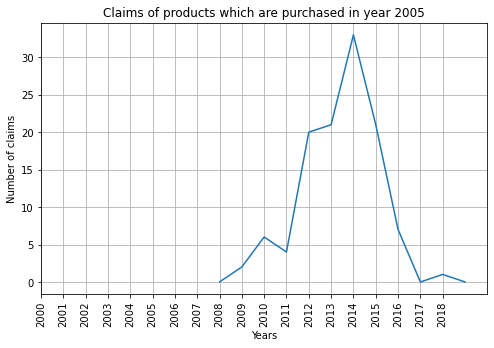

min year 2008


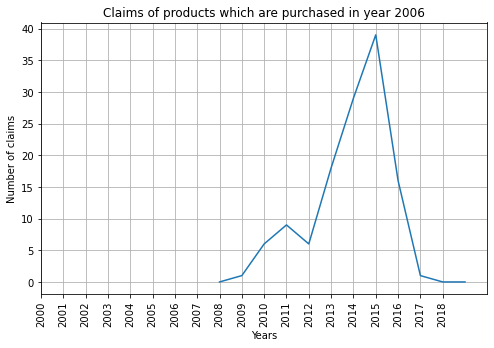

min year 2008


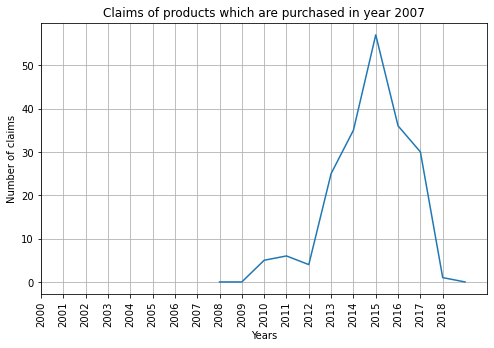

min year 2008


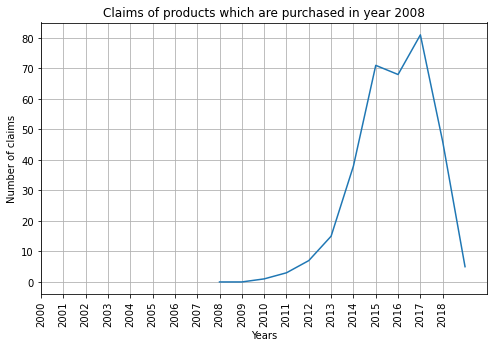

min year 2009


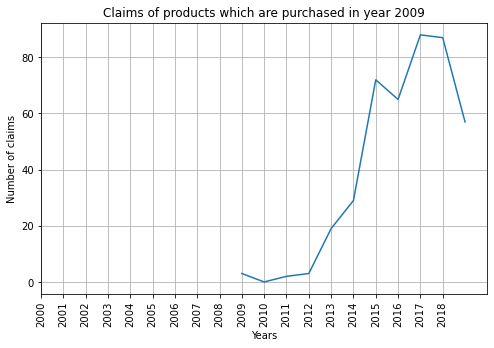

min year 2010


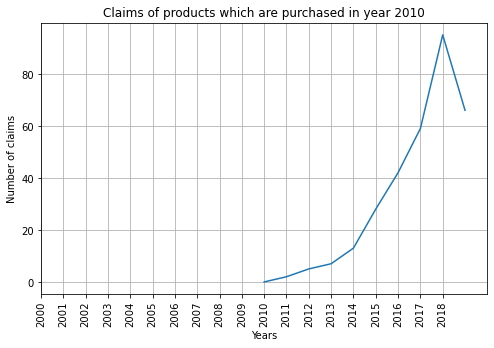

min year 2011


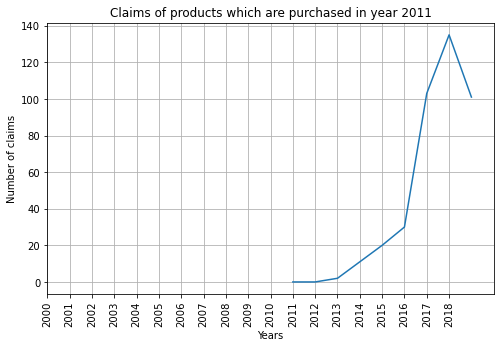

min year 2012


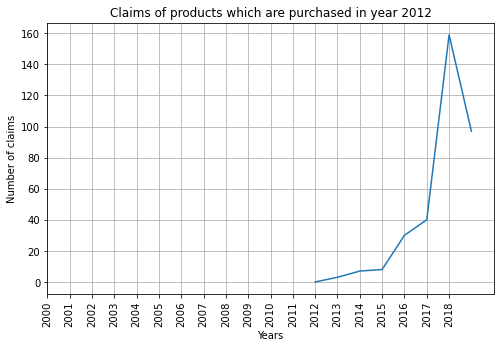

min year 2013


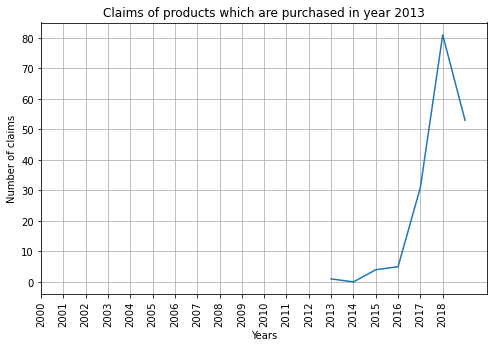

min year 2014


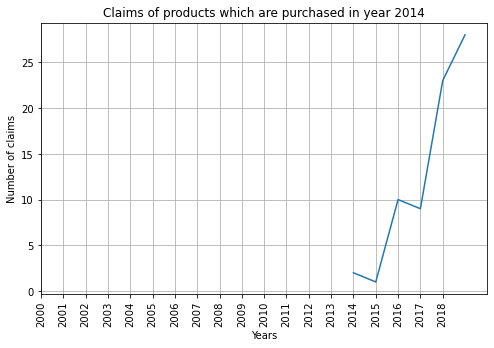

min year 2015


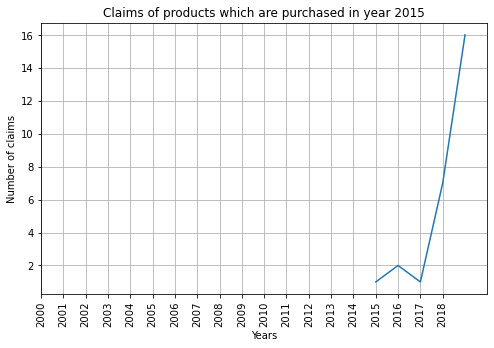

min year 2016


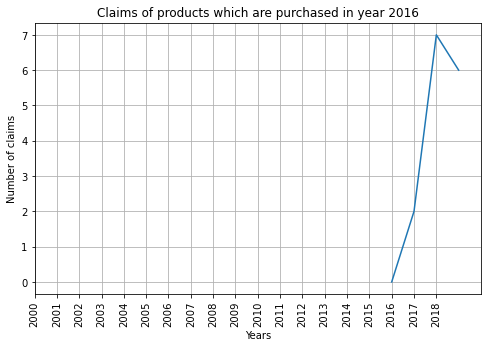

min year 2017


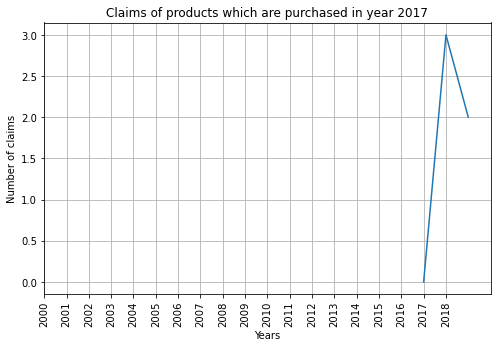

min year 2018


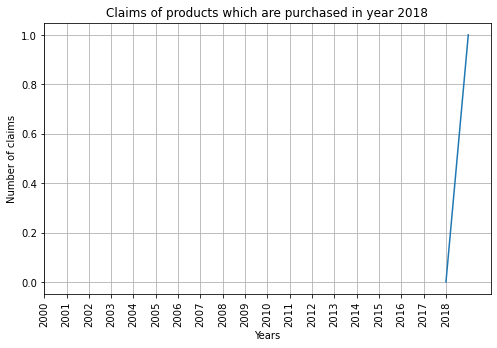

In [59]:
# distribution of claims from manufacturing year for next 10 years from 2000 manufacturing year
start_year=2000
end_year=2018
import matplotlib as mpl
clean_data2=clean_data_mfg_cl.copy()

for y in range(start_year,end_year+1):
    fig, ax = plt.subplots(figsize=(8,5))
    #ignore column Total
    s=clean_data2.loc[:, clean_data2.columns != 'Total']
    #get the columns where value >= y
    sel_col=[c for c in s.columns.tolist() if c>=y]
    print('min year',min(sel_col))
    s=s[sel_col]
    #s=s.loc[y,clean_data2.columns != 'Total']
    s=s.loc[y,:]
    #print(s.index)
    plt.plot(s.index,s.values,label='HI')
    #plt.hist(s.index,s.values)  #, 3  ) #, alpha=0.5)  #, label='x')
    #plt.hist(s.values)  #,label='HI')
    plt.xlim(2000,2020)
    plt.title('Claims of products which are purchased in year '+str(y))
    plt.xticks(list(range(start_year,end_year+1)),rotation=90)
    plt.xlabel('Years')
    plt.ylabel('Number of claims')
    plt.grid()
    plt.show()
    #break    
    
    

#### mfg squars dist

min year 2008


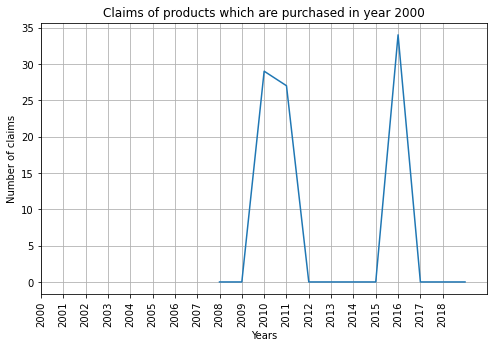

min year 2008


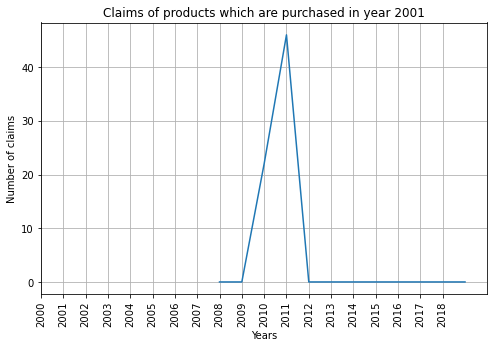

min year 2008


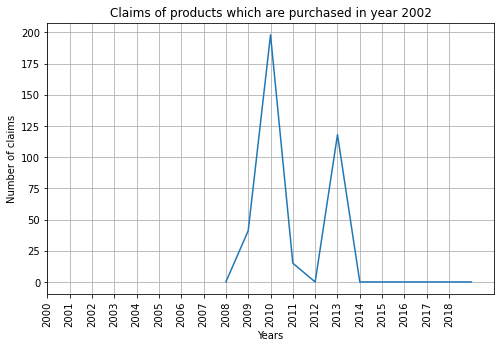

min year 2008


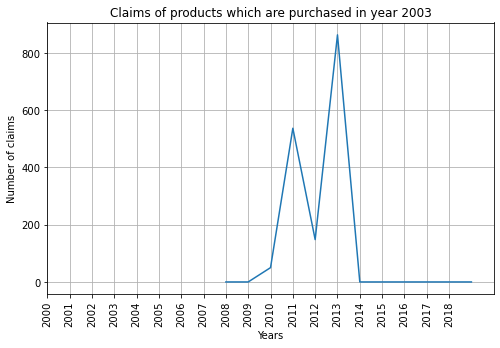

min year 2008


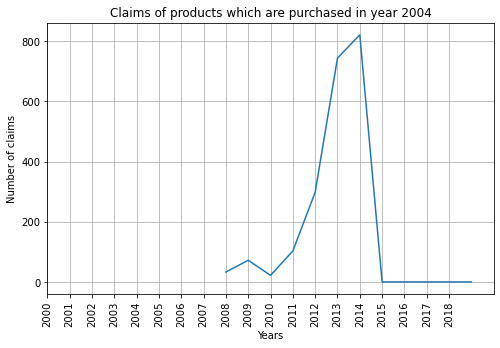

min year 2008


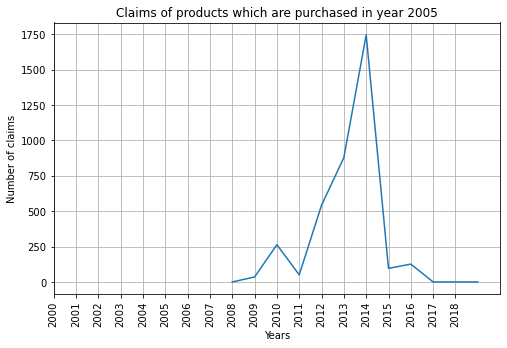

min year 2008


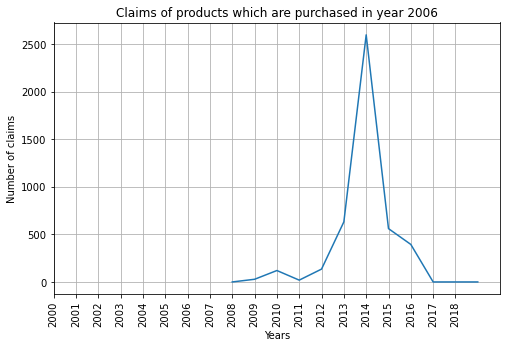

min year 2008


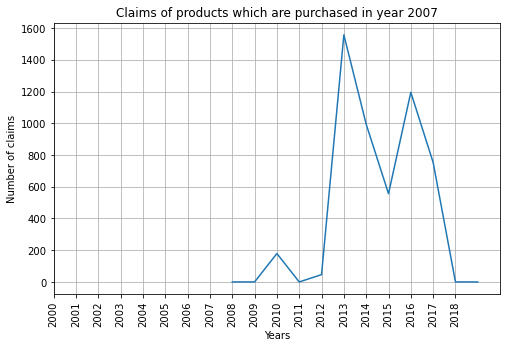

min year 2008


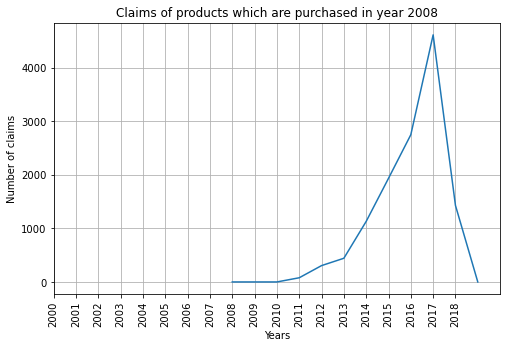

min year 2009


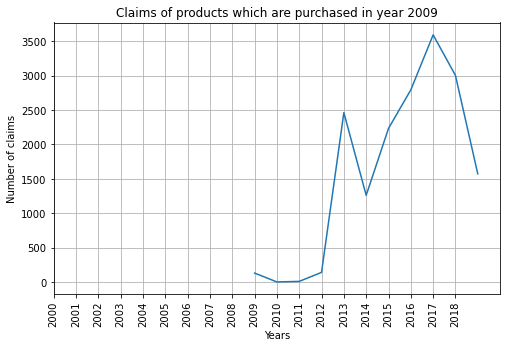

min year 2010


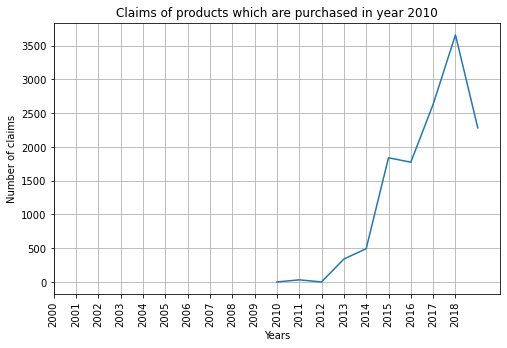

min year 2011


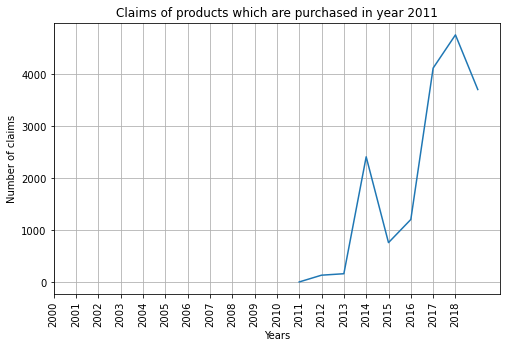

min year 2012


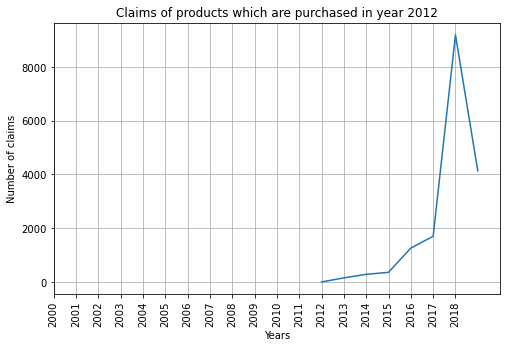

min year 2013


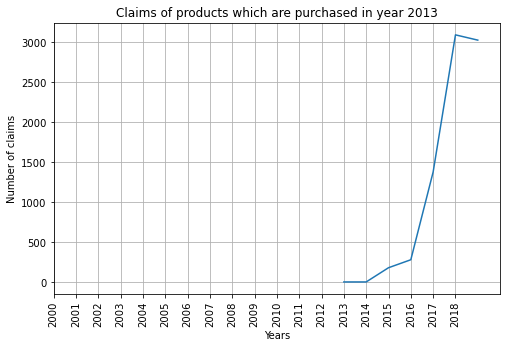

min year 2014


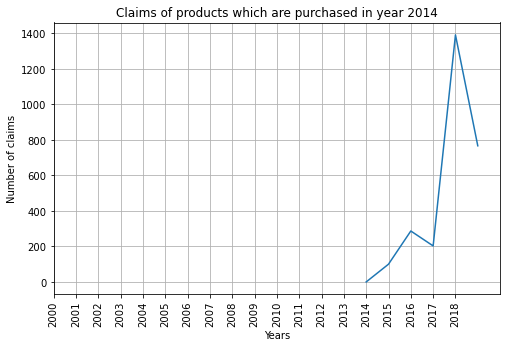

min year 2015


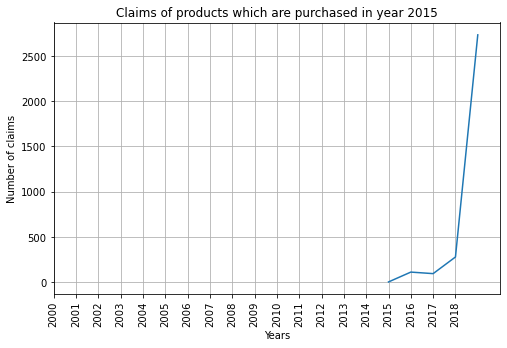

min year 2016


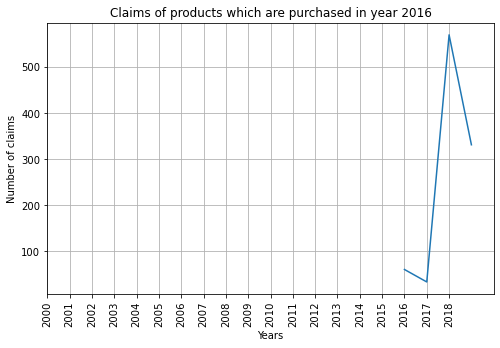

min year 2017


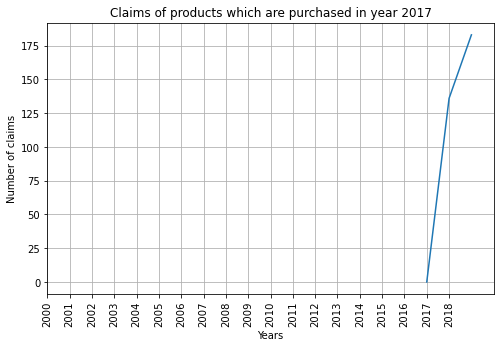

min year 2018


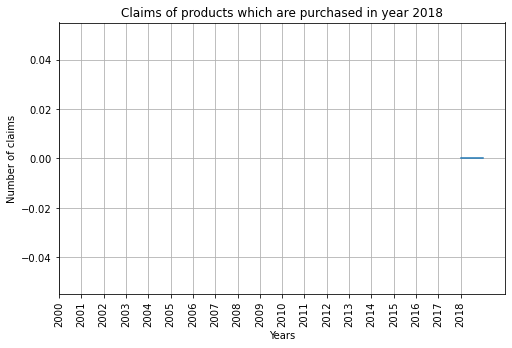

In [60]:
# distribution of claims from manufacturing year for next 10 years from 2000 manufacturing year
start_year=2000
end_year=2018
import matplotlib as mpl
clean_data2=clean_data_pur_sq.copy()

for y in range(start_year,end_year+1):
    fig, ax = plt.subplots(figsize=(8,5))
    #ignore column Total
    s=clean_data2.loc[:, clean_data2.columns != 'Total']
    #get the columns where value >= y
    sel_col=[c for c in s.columns.tolist() if c>=y]
    print('min year',min(sel_col))
    s=s[sel_col]
    #s=s.loc[y,clean_data2.columns != 'Total']
    s=s.loc[y,:]
    #print(s.index)
    plt.plot(s.index,s.values,label='HI')
    #plt.hist(s.index,s.values)  #, 3  ) #, alpha=0.5)  #, label='x')
    #plt.hist(s.values)  #,label='HI')
    plt.xlim(2000,2020)
    plt.title('Claims of products which are purchased in year '+str(y))
    plt.xticks(list(range(start_year,end_year+1)),rotation=90)
    plt.xlabel('Years')
    plt.ylabel('Number of claims')
    plt.grid()
    plt.show()
    #break    
    
    

In [186]:
s=clean_data2.loc[y,clean_data2.columns != 'Total']
#[c for c in clean_data2.columns.tolist() if c>=y]
clean_data2.columns.tolist()
[c for c in clean_data2.columns.tolist() if int(c)>=y]


ValueError: invalid literal for int() with base 10: 'Total'

In [147]:
df.reset_index().pivot('man_year','claim_year','claim_sq')
len(range(0,9))

9

In [179]:
clean_data2[clean_data2.index>'2002']

TypeError: '>' not supported between instances of 'int' and 'str'